# Try gapfilling frk with bet and bet2

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, correlate, correlation_lags, find_peaks_cwt
from scipy.integrate import trapz
from datetime import datetime, timedelta
from vtools.functions.filter import cosine_lanczos
from vtools.data.vtime import days, hours, minutes
from sklearn.linear_model import LinearRegression

/global/home/users/jennaisrael/.conda/envs/schimpy/lib/python3.7/site-packages/dask/dataframe/utils.py:15: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# vtools function

In [3]:
#vtools gap.py
#https://github.com/CADWRDeltaModeling/vtools3/blob/master/vtools/data/gap.py
import pandas as pd
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np
from enum import Enum, auto
from dataclasses import dataclass
from typing import Callable, Dict, List, Optional, Tuple

__all__ = ["gap_count", "gap_size", "gap_distance"]


def gap_count(ts, state="gap", dtype=int):
    """Count missing data
    Identifies gaps (runs of missing or non-missing data) and quantifies the
    length of the gap in terms of number of samples, which works better for
    regular series. Each time point receives the length of the run.

    Parameters
    ----------

    ts : :class:`DataFrame <pandas:pandas.DataFrame>`
        Time series to analyze

    state : `str` one of 'gap'|'good'|'both'
        State to count. If state is gap, block size of missing data are counted
        and reported for time points in the gap (every point in a given gap will
        receive the same value). Non missing data will have a size of zero.
        Setting state to 'good' inverts this -- missing blocks are reported as
        zero and good data are counted.

    dtype : `str` or `type`
        Data type of output, should be acceptable to
        pandas :meth:`astype <pandas:pandas.DataFrame.astype>`

    """

    def column_gap_count(ser):
        s = ser.index.to_series()
        tsout = ser.fillna(0).astype(dtype)
        miss = ser.isna()
        # create consecutive groups that increment each time the "is missing state" (na or not na) changes
        g = miss.ne(miss.shift()).cumsum()

        # identify beginning (min time) of each state
        count = s.groupby(g).count()

        # g contains a group index for each member of out, and here
        # we map g to out which has cumulative time
        tsout = g.map(count)
        if state == "gap":
            tsout.loc[~miss] = 0
        elif state == "good":
            tsout.loc[miss] = 0
        return tsout

    if hasattr(ts, "columns"):
        return ts.apply(column_gap_count, axis=0, result_type="broadcast").astype(dtype)
    else:
        return column_gap_count(ts).astype(dtype)


def gap_size(ts):
    """
    Identifies gaps (runs of missing data) and quantifies the
    length of the gap. Each time point receives the length of the run
    in terms of seconds or number of values in the time dimension,
    with non-missing data returning zero. Time is measured from the time the
    data first started being missing to when the data first starts being not missing
    .

    Parameters
    ----------

    ts : :class:`DataFrame <pandas:pandas.DataFrame>`

    Returns
    -------
    result : :class:`DataFrame <pandas:pandas.DataFrame>`
        A new regular time series with the same freq as the argument
        holding the size of the gap.

    Examples
    --------
    >>> ndx = pd.date_range(pd.Timestamp(2017,1,1,12),freq='15min',periods=10)
    >>> vals0 = np.arange(0.,10.,dtype='d')
    >>> vals1 = np.arange(0.,10.,dtype='d')
    >>> vals2 =  np.arange(0.,10.,dtype='d')
    >>> vals0[0:3] = np.nan
    >>> vals0[7:-1] = np.nan
    >>> vals1[2:4] = np.nan>>>
    >>> vals1[6] = np.nan
    >>> vals1[9] = np.nan

    >>> df = pd.DataFrame({'vals0':vals0,'vals1':vals1,'vals2':vals2},index = ndx)
    >>> out = gap_size(df)
    >>> print(df)
                             vals0  vals1  vals2
    2017-01-01 12:00:00    NaN    0.0    0.0
    2017-01-01 12:15:00    NaN    1.0    1.0
    2017-01-01 12:30:00    NaN    NaN    2.0
    2017-01-01 12:45:00    3.0    NaN    3.0
    2017-01-01 13:00:00    4.0    4.0    4.0
    2017-01-01 13:15:00    5.0    5.0    5.0
    2017-01-01 13:30:00    6.0    NaN    6.0
    2017-01-01 13:45:00    NaN    7.0    7.0
    2017-01-01 14:00:00    NaN    8.0    8.0
    2017-01-01 14:15:00    9.0    NaN    9.0
    >>> print(out)
                             vals0  vals1  vals2
    2017-01-01 12:00:00   45.0    0.0    0.0
    2017-01-01 12:15:00   45.0    0.0    0.0
    2017-01-01 12:30:00   45.0   30.0    0.0
    2017-01-01 12:45:00    0.0   30.0    0.0
    2017-01-01 13:00:00    0.0    0.0    0.0
    2017-01-01 13:15:00    0.0    0.0    0.0
    2017-01-01 13:30:00    0.0   15.0    0.0
    2017-01-01 13:45:00   30.0    0.0    0.0
    2017-01-01 14:00:00   30.0    0.0    0.0
    2017-01-01 14:15:00    0.0    0.0    0.0

    """

    ts_out = ts * 0.0

    s = ts.index.to_series()
    for c in ts.columns:
        # test missing values
        miss = ts[c].isna()
        # create consecutive groups that increment each time the "is missing state" (na or not na) changes
        g = miss.ne(miss.shift()).cumsum()
        # identify beginning (min time) of each state
        m1 = s.groupby(g).min()

        # get beginning of next groups, last value is replaced last value of index
        m2 = m1.shift(-1).fillna(ts.index[-1])

        # get difference, convert to minutes
        diffs = m2.sub(m1).dt.total_seconds().div(60).astype(int)

        # g contains a group index for each member of out, and here
        # we map g to out which has cumulative time
        ts_out[c] = g.map(diffs)
        ts_out.loc[~miss, c] = 0.0
    return ts_out


def gap_distance(ts, disttype="count", to="good"):
    """
    For each element of ts, count the distance to the nearest good data/or bad data.

    Parameters
    ----------

    ts : :class:`DataFrame <pandas:pandas.DataFrame>`
    Time series to analyze

    disttype : `str` one of 'bad'|'good'
    If disttype = "count" this is the number of values. If dist_type="freq" it is in the units of ts.freq
    (so if freq == "15min" it is in minutes")

    to : `str` one of 'bad'|'good'

    If to = "good" this is the distance to the nearest good data (which is 0 for good data).
    If to = "bad", this is the distance to the nearest nan (which is 0 for nan).

    Returns
    -------
    result : :class:`DataFrame <pandas:pandas.DataFrame>`
        A new regular time series with the same freq as the argument
        holding the distance of good/bad data.

    """
    si = ts.index.to_series()
    ts_out = ts.to_frame() if isinstance(ts, pd.Series) else ts.copy()
    cols = ts_out.columns
    for col in cols:
        id_key = True
        # test missing values
        miss = ts_out[col].isna()
        if to == "good":
            ts_out.at[~miss, col] = 0
        elif to == "bad":
            ts_out.at[miss, col] = 0
            id_key = False
        else:
            raise ValueError("invalid input to, must be good or bad")

        if np.any(miss == (id_key)):
            mm = si.groupby(miss).indices
            for i in mm[id_key]:
                # ts_out.iloc[i][col]=np.min(np.abs(i-mm[not(id_key)]))
                ts_out.at[si[i], col] = np.min(np.abs(i - mm[not (id_key)]))

    if disttype == "count":
        return ts_out
    elif disttype == "freq":
        return ts_out * ts.index.freq
    else:
        raise ValueError("invalid input disttype, must be count or freq")




def describe_series_gaps(s: pd.Series, name: str, context: int = 2):
    """
    Print gaps in a single Series s, showing `context` non-null points
    before and after each gap, with an ellipsis marker in between.
    """
    mask = s.isna().to_numpy()
    idx = s.index.to_numpy()

    if not mask.any():
        print(f"{name}: no missing values\n")
        return

    # find rising edges (gap starts) and falling edges (gap ends)
    diffs = np.diff(mask.astype(int), prepend=0, append=0)
    starts = np.where(diffs == 1)[0]
    ends = np.where(diffs == -1)[0] - 1

    for i, (st, en) in enumerate(zip(starts, ends), 1):
        gap_len = en - st + 1
        print(f"\n{name} — gap #{i}:")
        print(f"  from {idx[st]} to {idx[en]}  ({gap_len} samples missing)")

        # pre-gap context
        pre_idxs = []
        j = st - 1
        while j >= 0 and len(pre_idxs) < context:
            if not mask[j]:
                pre_idxs.append(j)
            j -= 1
        for pi in reversed(pre_idxs):
            print(f"    → {idx[pi]} : {s.iloc[pi]}")

        # ellipsis marker
        print("    ... [ missing block ] ...")

        # post-gap context
        post_idxs = []
        j = en + 1
        N = len(mask)
        while j < N and len(post_idxs) < context:
            if not mask[j]:
                post_idxs.append(j)
            j += 1
        for pi in post_idxs:
            print(f"    ← {idx[pi]} : {s.iloc[pi]}")
    print()


def describe_null(dset, name, context=2):
    """
    If dset is a DataFrame, run describe_series_gaps on each column.
    If it's a Series, just run it once.
    """
    if isinstance(dset, pd.DataFrame):
        for col in dset.columns:
            describe_series_gaps(dset[col], f"{name}.{col}", context=context)
    else:
        describe_series_gaps(dset, name, context=context)


def example_gap():


    ndx = pd.date_range(pd.Timestamp(2017, 1, 1, 12), freq="15min", periods=10)
    vals0 = np.arange(0.0, 10.0, dtype="d")
    vals1 = vals0.copy()
    vals2 = vals0.copy()
    vals0[0:3] = np.nan
    vals0[7:-1] = np.nan
    vals1[2:4] = np.nan
    vals1[6] = np.nan
    vals1[9] = np.nan

    df = pd.DataFrame({"vals0": vals0, "vals1": vals1, "vals2": vals2}, index=ndx)
    out = gap_count(df)
    print(df)
    print(out)

    out = gap_distance(df)
    print("**")
    print(out)


 #---------------------------- Gap creation ----------------------------- #



class GapStrategy(Enum):
    """Where to create synthetic gaps."""
    TARGET_ONLY = auto()
    BOTH = auto()            # gap target and neighbor on the same windows
    STAGGERED = auto()       # gap target and neighbor on different windows


@dataclass
class GapSpec:
    n_gaps: int = 60
    min_len: int = 70
    max_len: int = 900
    seed: Optional[int] = 123
    strategy: GapStrategy = GapStrategy.TARGET_ONLY
    ensure_room: int = 2  # min number of intact points between gaps


def _choose_gap_windows(n: int, spec: GapSpec) -> List[Tuple[int, int]]:
    rng = np.random.default_rng(spec.seed)
    windows: List[Tuple[int, int]] = []
    attempts = 0
    while len(windows) < spec.n_gaps and attempts < spec.n_gaps * 100:
        attempts += 1
        length = int(rng.integers(spec.min_len, spec.max_len + 1))
        start = int(rng.integers(0, max(1, n - length)))
        end = start + length
        # enforce spacing and non-overlap
        ok = True
        for (s0, e0) in windows:
            if not (end + spec.ensure_room <= s0 or start >= e0 + spec.ensure_room):
                ok = False
                break
        if ok:
            windows.append((start, min(n, end)))
    windows.sort()
    return windows


# def apply_gaps(
#     target: pd.Series,
#     neighbor: pd.Series | pd.DataFrame,
#     spec: GapSpec,
# ) -> Tuple[pd.Series, pd.Series | pd.DataFrame, Dict[str, List[Tuple[pd.Timestamp, pd.Timestamp]]]]:
#     """Apply synthetic gaps to target and/or neighbor.

#     Parameters
#     ----------
#     target, neighbor : time-aligned inputs
#     spec : GapSpec

#     Returns
#     -------
#     (target_gapped, neighbor_gapped, gap_windows)
#         - `gap_windows` provides timestamp ranges actually masked under keys
#           'target' and possibly 'neighbor'.
#     """
#     idx = target.index
#     n = len(idx)
#     gaps_t = _choose_gap_windows(n, spec)

#     def _mask_series(s: pd.Series, windows: List[Tuple[int, int]]):
#         m = s.copy()
#         for (i0, i1) in windows:
#             m.iloc[i0:i1] = np.nan
#         return m

#     # Decide neighbor gaps
#     if spec.strategy == GapStrategy.TARGET_ONLY:
#         gaps_n: List[Tuple[int, int]] = []
#     elif spec.strategy == GapStrategy.BOTH:
#         gaps_n = gaps_t
#     else:  # STAGGERED
#         # Draw new windows for neighbor
#         gaps_n = _choose_gap_windows(n, spec)

#     t_gap = _mask_series(target, gaps_t)
#     if isinstance(neighbor, pd.DataFrame):
#         n_gap = neighbor.copy()
#         for col in n_gap.columns:
#             n_gap[col] = _mask_series(n_gap[col], gaps_n)
#     else:
#         n_gap = _mask_series(neighbor, gaps_n)

#     # Build human-readable windows with timestamps
#     to_ts = lambda w: (idx[w[0]], idx[min(len(idx)-1, w[1]-1)])
#     gap_dict = {
#         "target": [to_ts(w) for w in gaps_t],
#         "neighbor": [to_ts(w) for w in gaps_n],
#     }
#     return t_gap, n_gap, gap_dict



if __name__ == "__main__":
    example_gap()

                     vals0  vals1  vals2
2017-01-01 12:00:00    NaN    0.0    0.0
2017-01-01 12:15:00    NaN    1.0    1.0
2017-01-01 12:30:00    NaN    NaN    2.0
2017-01-01 12:45:00    3.0    NaN    3.0
2017-01-01 13:00:00    4.0    4.0    4.0
2017-01-01 13:15:00    5.0    5.0    5.0
2017-01-01 13:30:00    6.0    NaN    6.0
2017-01-01 13:45:00    NaN    7.0    7.0
2017-01-01 14:00:00    NaN    8.0    8.0
2017-01-01 14:15:00    9.0    NaN    9.0
                     vals0  vals1  vals2
2017-01-01 12:00:00      3      0      0
2017-01-01 12:15:00      3      0      0
2017-01-01 12:30:00      3      2      0
2017-01-01 12:45:00      0      2      0
2017-01-01 13:00:00      0      0      0
2017-01-01 13:15:00      0      0      0
2017-01-01 13:30:00      0      1      0
2017-01-01 13:45:00      2      0      0
2017-01-01 14:00:00      2      0      0
2017-01-01 14:15:00      0      1      0
**
                     vals0  vals1  vals2
2017-01-01 12:00:00    3.0    0.0    0.0
2017-01-01 12

# Functions for filtering and gap counting

In [4]:
#function comes from schimpy metricsplot.py script https://github.com/CADWRDeltaModeling/schimpy/blob/master/schimpy/metricsplot.py
def filter_timeseries(tss, cutoff_period=hours(40)):
    """ Filter time series

        Parameters
        ----------

        Returns
        -------
        list of vtools.data.timeseries.TimeSeries
            filtered time series
    """

    filtered = []
    ts=tss #try removing the loop for now
    if ts is None:
        filtered.append(None)
    else:
        #print(ts)
        ts_filtered = cosine_lanczos(ts, cutoff_period=cutoff_period)
        ts_filtered.filtered = 'cosine_lanczos'
        #ts_filtered.unit = ts.unit
        #filtered.append(ts_filtered)
    # for ts in tss:
    #     if ts is None:
    #         filtered.append(None)
    #     else:
    #         print(ts)
    #         ts_filtered = cosine_lanczos(ts, cutoff_period=cutoff_period)
    #         ts_filtered.filtered = 'cosine_lanczos'
    #         ts_filtered.unit = ts.unit
    #         filtered.append(ts_filtered)
    return ts_filtered

In [5]:
def find_gaps(sjj_dms,gapmin,gapmax=np.nan):
    #where sjj is a salinity pandas df with a time index and gapmin is type pd.Timedelta minimum gap length
    #and the output is the good index before and the good index after the gap
    freq=sjj_dms.index[1]-sjj_dms.index[0]
    sjj_dropna=sjj_dms.dropna()
    sjj_dropna['date_col']=np.array([d.to_datetime64() for d in sjj_dropna.index])
    sjj_dropna['gap']=sjj_dropna.date_col.diff()
    #gapmin1=pd.Timedelta('16 min')
    if pd.isnull(gapmax):
        mask=sjj_dropna.date_col.diff().gt(gapmin)
    else:
        mask1=sjj_dropna.date_col.diff().lt(gapmax)
        mask2=sjj_dropna.date_col.diff().gt(gapmin)
        mask=mask1*mask2 # if true in both cases, will be true in the product
    # get values
    starts = sjj_dropna.loc[mask.shift(-1, fill_value=False), 'date_col'].add(freq).astype(str)
    stops = sjj_dropna.loc[mask, 'date_col'].sub(freq).astype(str)
    # build output
    out = list(zip(starts, stops))
    return out


In [6]:
# def fill_small_gaps(sjj_dms,gapmax):
#     #where sjj is a salinity pandas df with a time index and gapmin is type pd.Timedelta minimum gap length
#     #and the output is the good index before and the good index after the gap
#     freq=sjj_dms.index[1]-sjj_dms.index[0]
#     sjj_dropna=sjj_dms.dropna()
#     sjj_dropna['date_col']=np.array([d.to_datetime64() for d in sjj_dropna.index])
#     sjj_dropna['gap']=sjj_dropna.date_col.diff()
#     #gapmin1=pd.Timedelta('16 min')
#     mask1=sjj_dropna.date_col.diff().lt(gapmax)
#     # get values
#     starts = sjj_dropna.loc[mask1.shift(-1, fill_value=False), 'date_col'].add(freq).astype(str)
#     stops = sjj_dropna.loc[mask1, 'date_col'].sub(freq).astype(str)
#      # build output
#     out = list(zip(starts, stops))
#     return out

# Load the salinity data

In [7]:
dtformat = '%Y-%m-%dT%H:%M:%S'
frk_dms=pd.read_csv('/global/scratch/users/jennaisrael/climate_data_processing/identify_stp/frkdefault_ec_screened_2021.csv',skiprows=65)#.set_index('datetime')
frk_dms=frk_dms.rename(columns={"value": "Salinity[microS/cm]"})
#drop the user flag column
frk_dms=frk_dms.drop(columns='user_flag')
frk_dms['datetime']=pd.to_datetime(frk_dms['datetime'],format=dtformat)
frk_dms.set_index("datetime",inplace=True)
frk_dms=frk_dms.asfreq('15min')

bet_dms=pd.read_csv("/global/scratch/users/jennaisrael/time_varying_data/dmsdatastore/salinity/dms_data_bet.csv")
bet_dms=bet_dms.rename(columns={"screened/bet//dwr_ncro/B95058/ec/Unknown": "Salinity[microS/cm]"})
bet_dms['datetime']=pd.to_datetime(bet_dms['datetime'],format=dtformat)
bet_dms.set_index("datetime",inplace=True)
bet_dms=bet_dms.asfreq('15min')

bet2_dms=pd.read_csv("/global/scratch/users/jennaisrael/time_varying_data/dmsdatastore/salinity/dms_data_bet2.csv")
bet2_dms=bet2_dms.rename(columns={"screened/bet2//dwr_ncro/B95045/ec/Unknown": "Salinity[microS/cm]"})
bet2_dms['datetime']=pd.to_datetime(bet2_dms['datetime'],format=dtformat)
bet2_dms.set_index("datetime",inplace=True)
bet2_dms=bet2_dms.asfreq('15min')


In [8]:
frk_dms

,Salinity[microS/cm]
datetime,
2015-07-01 00:00:00,790.0
2015-07-01 00:15:00,782.0
2015-07-01 00:30:00,779.0
2015-07-01 00:45:00,772.0
2015-07-01 01:00:00,766.0
...,...
2025-07-14 17:00:00,321.0
2025-07-14 17:15:00,320.0
2025-07-14 17:30:00,319.0


In [9]:
# gapmin=pd.Timedelta('16 min')
# gapmax=pd.Timedelta('121 min')
# freq=hol2_dms.index[1]-hol2_dms.index[0]
# hol2_dropna=hol2_dms.dropna()
# hol2_dropna['date_col']=np.array([d.to_datetime64() for d in hol2_dropna.index])
# hol2_dropna['gap']=hol2_dropna.date_col.diff()
# #gapmin1=pd.Timedelta('16 min')
# mask1=hol2_dropna.date_col.diff().lt(gapmax)
# mask2=hol2_dropna.date_col.diff().gt(gapmin)
# mask3=mask1*mask2
# #mask3
# sum(mask3)

# Fill gaps

In [10]:
def fill_small_gaps(station_dms,gapmin,gapmax):
    #where station_dms is the cleaned data vector to use (pandas dataframe, datetime index and column called "Salinity[microS/cm]" 
    #stationstr is the name of the station
    #gapmin is the the minimum gapsize to look for, should be just bigger than the signal frequency
    #gap max is the max size gap you want to fill with interpolation
    station_smallgaps=find_gaps(station_dms,gapmin,gapmax)
    station_sm_filled=station_dms.copy()
    for g in station_smallgaps:
        #to linearly interpolate we need the values on the other side
        start=pd.to_datetime(g[0])-pd.Timedelta('15min')
        end=pd.to_datetime(g[1])+pd.Timedelta('15min')
        dates2fill=pd.date_range(start,end,freq='15min')
        num2fill=len(dates2fill)
        if np.sum(np.isnan(station_sm_filled.loc[dates2fill]['Salinity[microS/cm]']))==num2fill-2:
            #print('gap is all nans')
            station_sm_filled['Salinity[microS/cm]'].loc[dates2fill]= station_dms['Salinity[microS/cm]'].loc[dates2fill].interpolate() #needs to be a 1D array #needs to be a 1D array
            #if np.sum(np.isnan(station_sm_filled.loc[dates2fill]['Salinity[microS/cm]']))== 0:
                #print('gap has been filled!')
        else:
            print('Not all nans! Check ' + g[0] +' to '+g[1])
    return station_sm_filled

In [11]:
# fill the gaps smaller than 2 hrs using linear interpolation
gapmin=pd.Timedelta('16 min')
gapmax=pd.Timedelta('121 min')
bet_sm_filled=fill_small_gaps(bet_dms,gapmin,gapmax)
bet2_sm_filled=fill_small_gaps(bet2_dms,gapmin,gapmax)
frk_sm_filled=fill_small_gaps(frk_dms,gapmin,gapmax)

/global/home/users/jennaisrael/.conda/envs/schimpy/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/global/home/users/jennaisrael/.conda/envs/schimpy/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/global/home/users/jennaisrael/.conda/envs/schimpy/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try 

In [12]:
frk_check=find_gaps(frk_sm_filled,gapmin,gapmax)
frk_check

/global/home/users/jennaisrael/.conda/envs/schimpy/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/global/home/users/jennaisrael/.conda/envs/schimpy/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


[]

In [13]:
bet_check=find_gaps(bet_sm_filled,gapmin,gapmax)
bet2_check=find_gaps(bet2_sm_filled,gapmin,gapmax)
print(bet_check)
print(bet2_check)

/global/home/users/jennaisrael/.conda/envs/schimpy/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/global/home/users/jennaisrael/.conda/envs/schimpy/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


[]
[]


/global/home/users/jennaisrael/.conda/envs/schimpy/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/global/home/users/jennaisrael/.conda/envs/schimpy/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


# What are the big gaps in frk and are they covered by bet and bet2? (do this for the raw data first)

In [14]:
gapmin=pd.Timedelta('122min')
frk_out=find_gaps(frk_dms,gapmin)
frk_out

/global/home/users/jennaisrael/.conda/envs/schimpy/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/global/home/users/jennaisrael/.conda/envs/schimpy/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


[('2021-06-21 02:45:00', '2021-07-07 09:15:00'),
 ('2021-07-11 17:45:00', '2021-07-17 15:30:00'),
 ('2021-09-29 23:45:00', '2021-09-30 06:30:00'),
 ('2022-01-13 10:45:00', '2022-01-13 12:30:00'),
 ('2022-12-20 10:15:00', '2022-12-20 13:00:00'),
 ('2023-10-17 08:00:00', '2023-10-17 10:45:00'),
 ('2024-05-27 08:30:00', '2024-05-27 10:45:00')]

#looks like frk has a few gaps
[('2021-06-21 02:45:00', '2021-07-07 09:15:00'),
 ('2021-07-11 17:45:00', '2021-07-17 15:30:00'),
 ('2021-09-29 23:45:00', '2021-09-30 06:30:00'),
 ('2022-01-13 10:45:00', '2022-01-13 12:30:00'),
 ('2022-12-20 10:15:00', '2022-12-20 13:00:00'),
 ('2023-10-17 08:00:00', '2023-10-17 10:45:00'),
 ('2024-05-27 08:30:00', '2024-05-27 10:45:00')]

In [15]:
gapmin=pd.Timedelta('122min')
bet_out=find_gaps(bet_dms,gapmin)
bet_out

/global/home/users/jennaisrael/.conda/envs/schimpy/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/global/home/users/jennaisrael/.conda/envs/schimpy/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


[('2013-02-12 08:45:00', '2013-02-12 14:30:00'),
 ('2014-09-15 06:45:00', '2014-09-18 08:15:00'),
 ('2014-12-11 15:15:00', '2014-12-11 19:45:00'),
 ('2014-12-11 21:00:00', '2014-12-12 05:00:00'),
 ('2015-10-17 01:15:00', '2015-10-20 09:45:00'),
 ('2016-05-16 10:30:00', '2016-07-14 08:30:00'),
 ('2016-08-29 09:45:00', '2016-10-11 09:00:00'),
 ('2016-10-28 08:30:00', '2016-10-28 10:15:00'),
 ('2016-11-20 17:00:00', '2016-11-20 18:45:00'),
 ('2017-05-09 09:15:00', '2020-12-31 23:45:00'),
 ('2021-01-13 11:15:00', '2021-01-20 13:45:00'),
 ('2021-02-04 12:30:00', '2021-02-04 15:15:00'),
 ('2021-02-06 12:30:00', '2021-02-06 14:15:00'),
 ('2021-02-07 14:30:00', '2021-02-07 17:15:00'),
 ('2021-02-08 14:30:00', '2021-02-08 18:15:00'),
 ('2021-02-10 11:30:00', '2021-02-10 20:15:00'),
 ('2021-02-12 11:30:00', '2021-02-19 07:15:00'),
 ('2021-04-18 01:30:00', '2021-04-18 09:15:00'),
 ('2021-07-21 21:30:00', '2021-07-22 07:15:00'),
 ('2021-09-30 14:30:00', '2021-09-30 17:15:00'),
 ('2022-02-24 16:30:

#pretty much all covered by bet, might need to interpolate to get from 2023-10-17 10:30:00 to 2023-10-17 10:45:00

In [16]:
gapmin=pd.Timedelta('122min')
bet2_out=find_gaps(bet2_dms,gapmin)
bet2_out

/global/home/users/jennaisrael/.conda/envs/schimpy/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/global/home/users/jennaisrael/.conda/envs/schimpy/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


[('2017-05-18 11:15:00', '2017-05-23 09:00:00'),
 ('2017-07-20 08:15:00', '2017-07-20 10:00:00'),
 ('2018-05-31 10:15:00', '2018-06-02 06:45:00'),
 ('2018-06-02 07:30:00', '2018-06-05 10:15:00'),
 ('2019-09-05 10:00:00', '2019-09-12 10:00:00'),
 ('2022-11-20 00:00:00', '2022-11-20 03:00:00'),
 ('2022-11-24 00:30:00', '2022-11-24 06:15:00'),
 ('2022-11-28 16:00:00', '2022-11-28 19:15:00'),
 ('2023-08-09 11:00:00', '2023-08-17 12:00:00'),
 ('2023-10-20 12:15:00', '2023-10-20 15:00:00'),
 ('2023-10-21 11:00:00', '2023-10-21 13:30:00'),
 ('2023-10-23 10:45:00', '2023-10-23 15:00:00'),
 ('2023-10-24 10:30:00', '2023-10-24 15:15:00'),
 ('2023-10-26 11:30:00', '2023-10-26 14:45:00'),
 ('2023-10-27 11:15:00', '2023-10-27 15:15:00'),
 ('2023-10-28 12:45:00', '2023-10-28 14:30:00'),
 ('2023-10-29 11:00:00', '2023-10-29 15:15:00'),
 ('2023-10-30 11:30:00', '2023-10-30 15:30:00'),
 ('2023-10-31 11:15:00', '2023-10-31 15:30:00'),
 ('2023-11-01 11:15:00', '2023-11-01 14:45:00'),
 ('2023-11-02 11:00:

#bet2 seems less gappy, see whoich has a better correlation

In [17]:
# # could we use hll during this period?
# hll_dms=pd.read_csv("/global/scratch/users/jennaisrael/time_varying_data/dmsdatastore/salinity/dms_data_hll.csv")
# hll_dms=hll_dms.rename(columns={"screened/hll//usbr/HLL/ec/microS/cm": "Salinity[mS/cm]"})
# hll_dms['datetime']=pd.to_datetime(hll_dms['datetime'],format=dtformat)
# hll_dms.set_index("datetime",inplace=True)
# hll_dms=hll_dms.asfreq('15min')

In [18]:
# gapmin=pd.Timedelta('122min')
# hll_out=find_gaps(hll_dms,gapmin)
# hll_out

#hll covers the bet2 gaps 

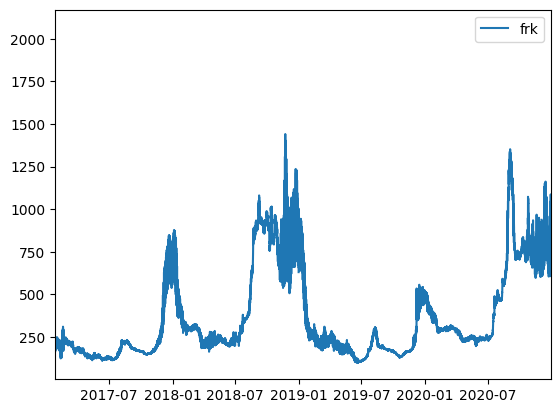

In [19]:
fig, ax =plt.subplots()
#plot hll, bet2, and frk
ax.plot(frk_dms,label='frk')
# ax.plot(bet2_dms,label='bet2')
# ax.plot(hll_dms,label='hll')
ax.set_xlim(datetime(2017,1,25),datetime(2020,12,30))
plt.legend()
plt.show()

# Yes I think bet/bet2 cover the gaps that are longer than a day for frk. 

In [20]:
#put the two signals in one dataframe and drop rows where either has a nan
hcomb=pd.concat([frk_dms.rename(columns={"Salinity[microS/cm]":"frk"}),
                 bet_dms.rename(columns={"Salinity[microS/cm]":"bet"}),
                bet2_dms.rename(columns={"Salinity[microS/cm]":"bet2"})],axis=1).dropna()
hcomb

,frk,bet,bet2
datetime,,,
2015-07-01 00:00:00,790.0,810.0,887.0
2015-07-01 00:15:00,782.0,808.0,885.8
2015-07-01 00:30:00,779.0,807.0,886.5
2015-07-01 00:45:00,772.0,803.0,887.7
2015-07-01 01:00:00,766.0,806.0,892.6
...,...,...,...
2025-07-14 16:45:00,322.0,290.0,290.4
2025-07-14 17:00:00,321.0,292.0,291.9
2025-07-14 17:15:00,320.0,291.0,290.9


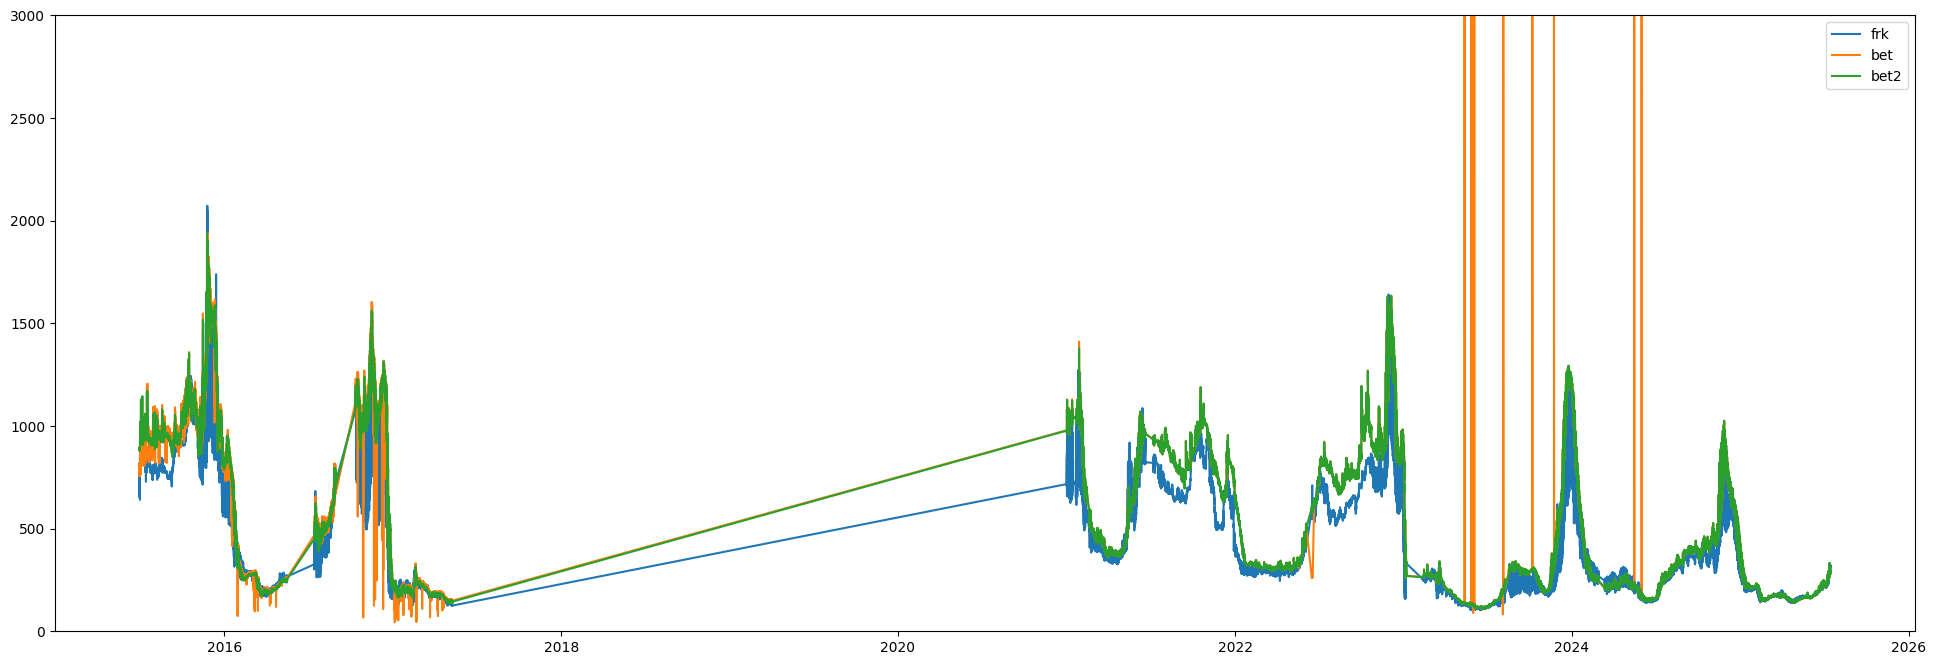

In [21]:

fig, ax = plt.subplots(figsize=(24,8))
ax.plot(hcomb.frk, label='frk')
ax.plot(hcomb.bet, label ='bet')
ax.plot(hcomb.bet2, label ='bet2')
ax.set_ylim(0,3000)
plt.legend()

In [22]:
# actually bet has some wonky values, stick with bet2

In [23]:
X= hcomb.bet2.values.reshape(-1, 1)
y= hcomb.frk.values.reshape(-1,1)
reg = LinearRegression().fit(X,y)

reg.score(X, y)

0.9383420394549834

In [24]:
print(reg.coef_)
print(reg.intercept_)
#print(reg.predict(np.array()))

[[0.77731259]]
[44.1720311]


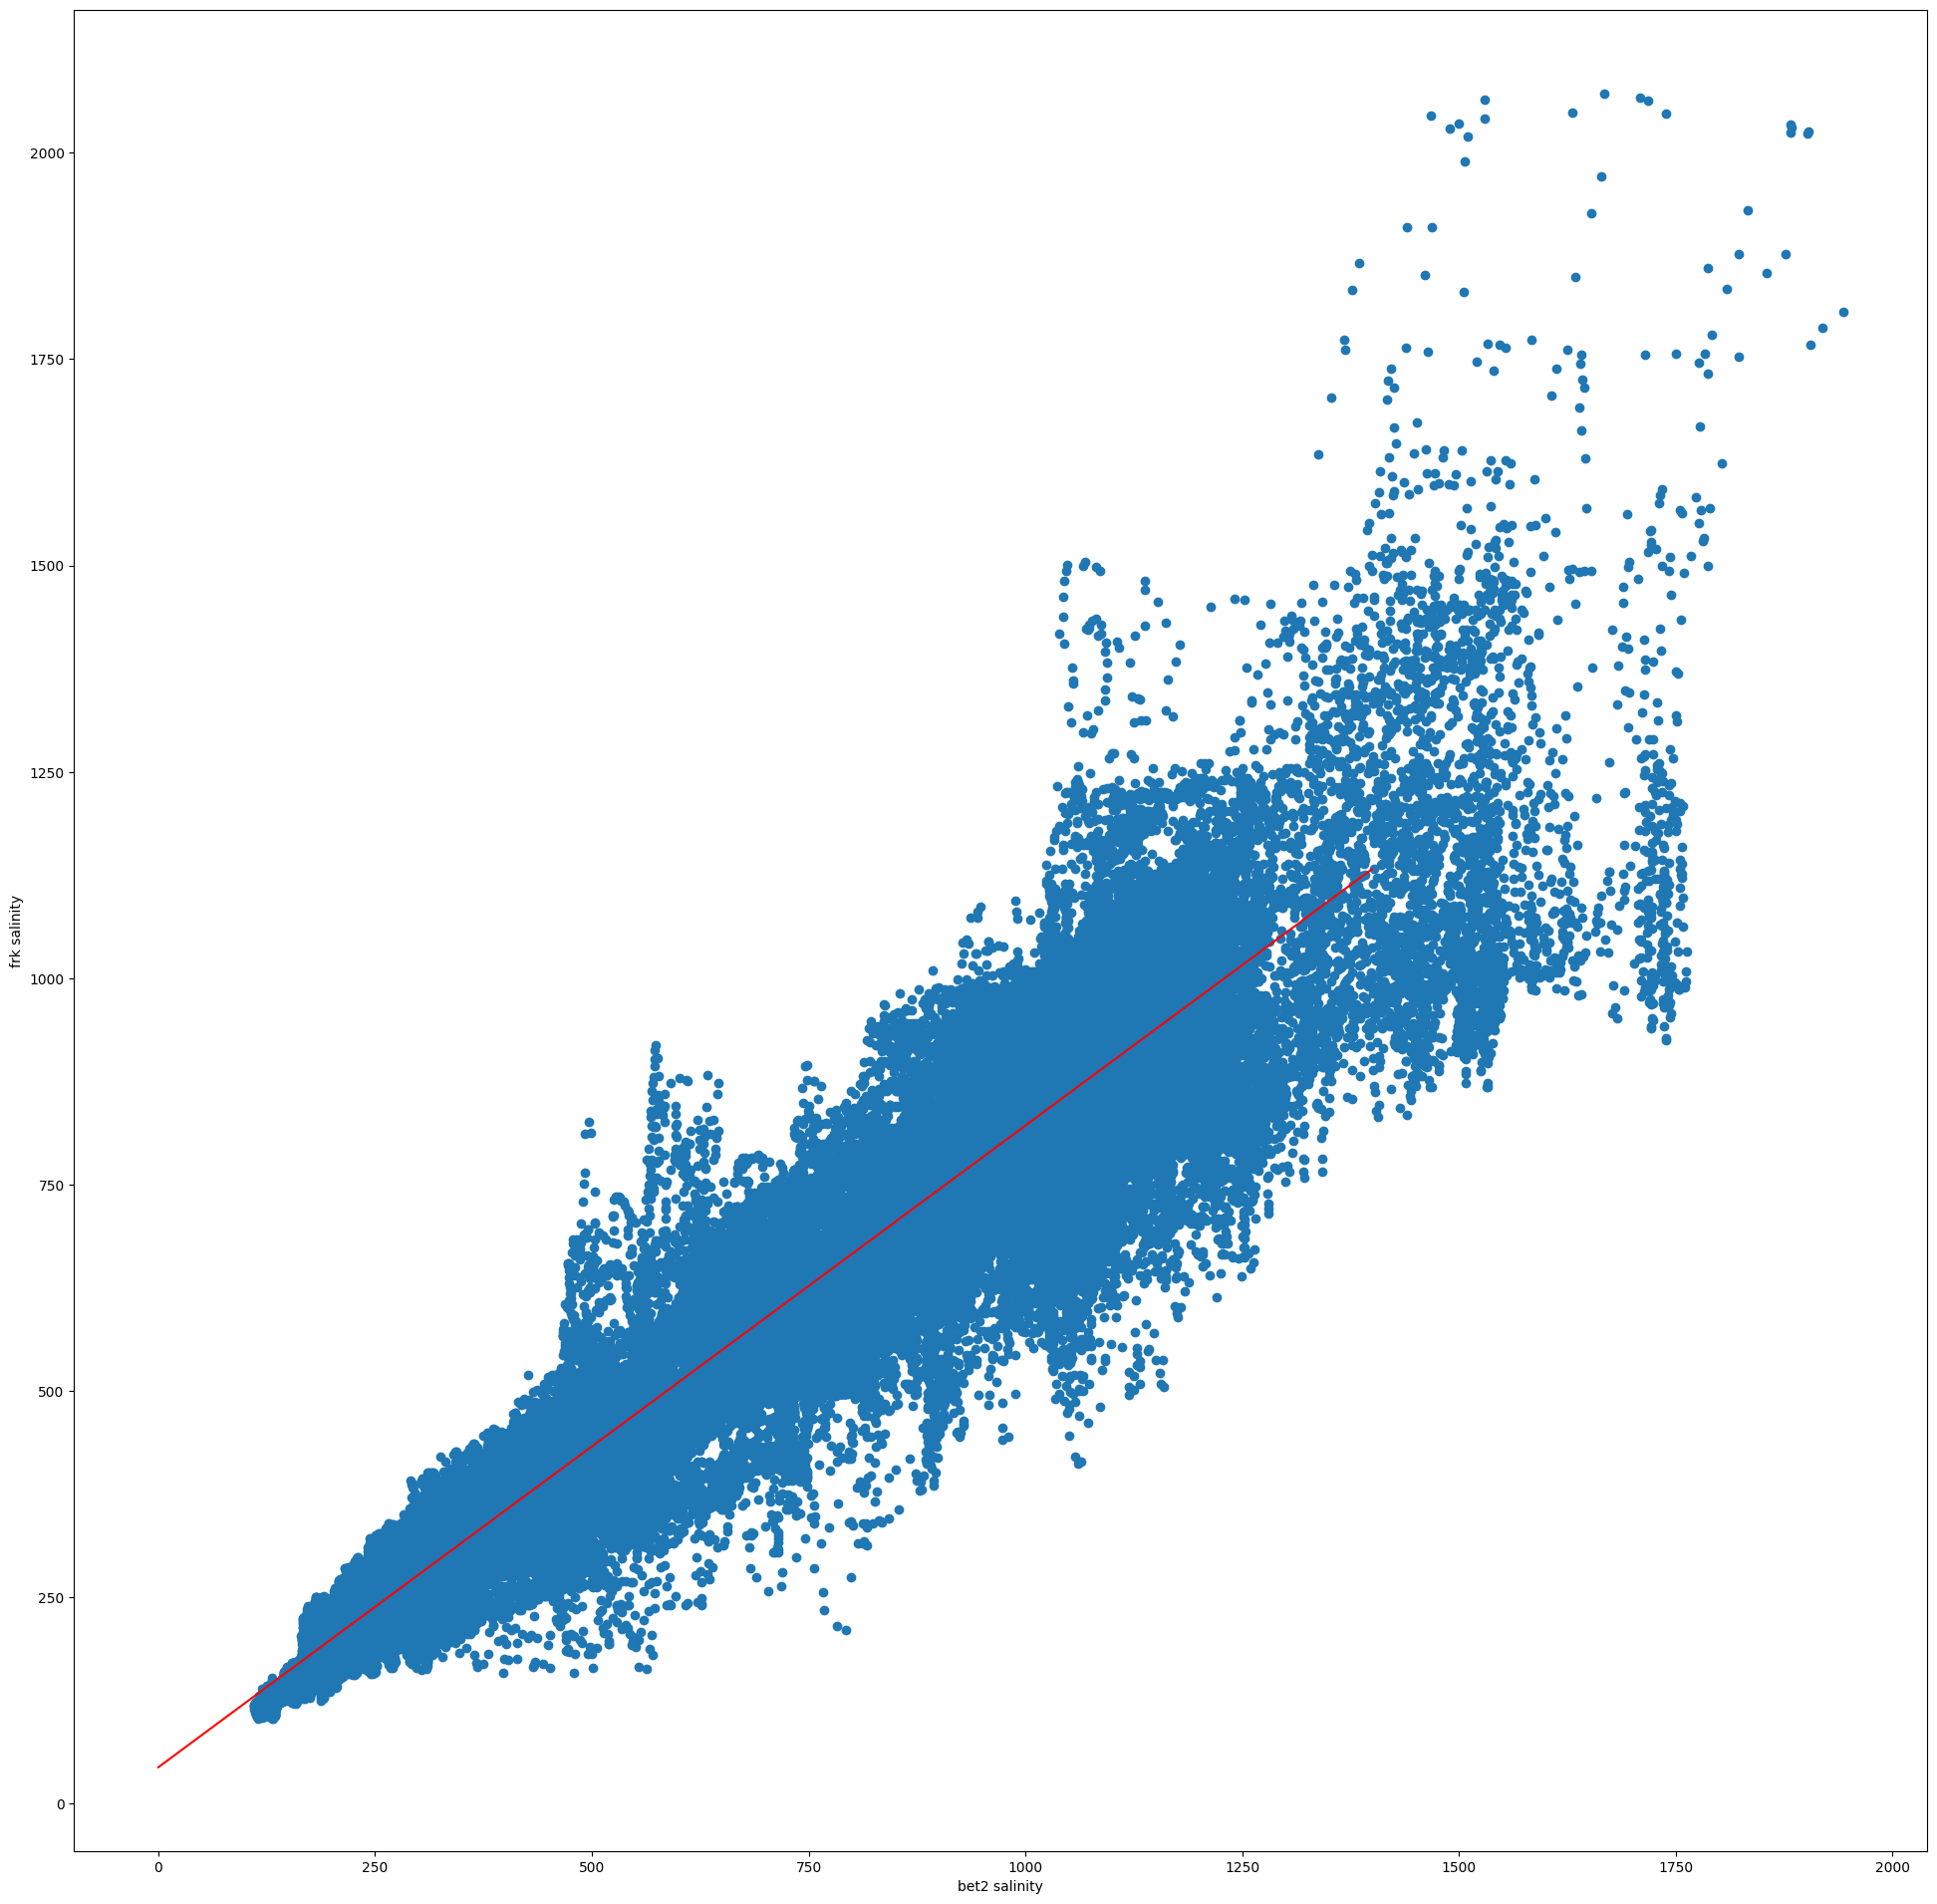

In [25]:
fig, ax = plt.subplots(figsize=(24,24))
ax.scatter(hcomb.bet2, hcomb.frk)
linx=np.linspace(0,1400)
liny=reg.coef_[0]*linx+reg.intercept_
ax.plot(linx,liny,color='red')
ax.set_ylabel('frk salinity')
ax.set_xlabel('bet2 salinity')
plt.show()

In [26]:
#try predicting what would go in the gaps
#first gap in frk: [('2021-06-21 02:45:00', '2021-07-07 09:15:00'),
 # ('2021-07-11 17:45:00', '2021-07-17 15:30:00'),
 # ('2021-09-29 23:45:00', '2021-09-30 06:30:00'),
 # ('2022-01-13 10:45:00', '2022-01-13 12:30:00'),
 # ('2022-12-20 10:15:00', '2022-12-20 13:00:00'),
 # ('2023-10-17 08:00:00', '2023-10-17 10:45:00'),
 # ('2024-05-27 08:30:00', '2024-05-27 10:45:00')]
frk_gap=bet2_dms.loc[pd.to_datetime('2021-06-21 02:45:00'):pd.to_datetime('2021-07-07 09:15:00')]
frk_pred=reg.predict(frk_gap.values.reshape(-1, 1))

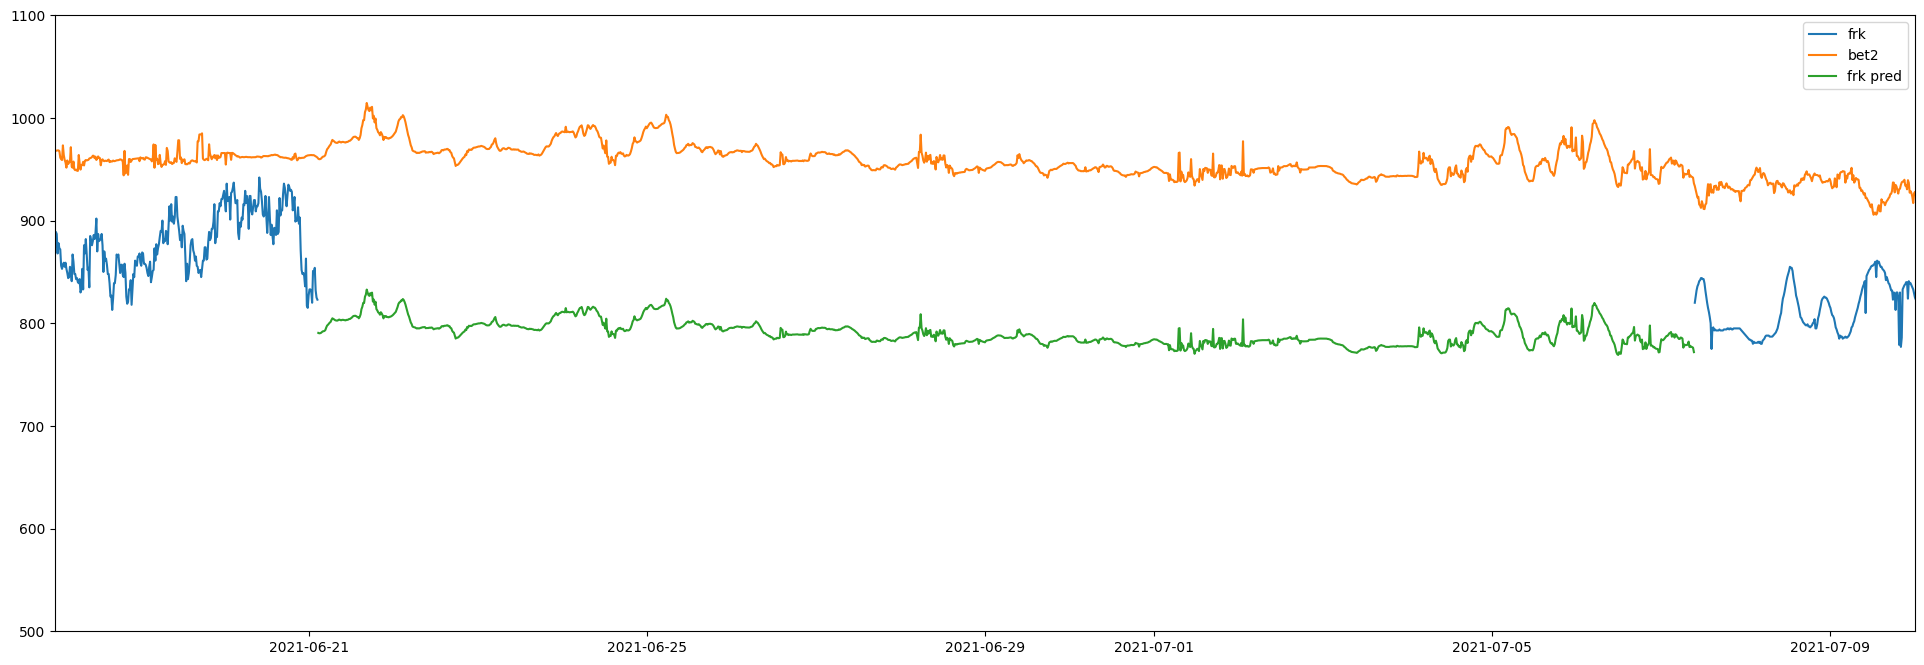

In [27]:
fig, ax = plt.subplots(figsize=(24,8))
ax.plot(frk_dms, label='frk')
ax.plot(bet2_dms, label ='bet2')
ax.plot(bet2_dms.loc[pd.to_datetime('2021-06-21 02:45:00'):pd.to_datetime('2021-07-07 09:15:00')].index,frk_pred,label='frk pred')
ax.set_xlim(datetime(2021,6,18),datetime(2021,7,10))
ax.set_ylim(500,1100)
plt.legend()

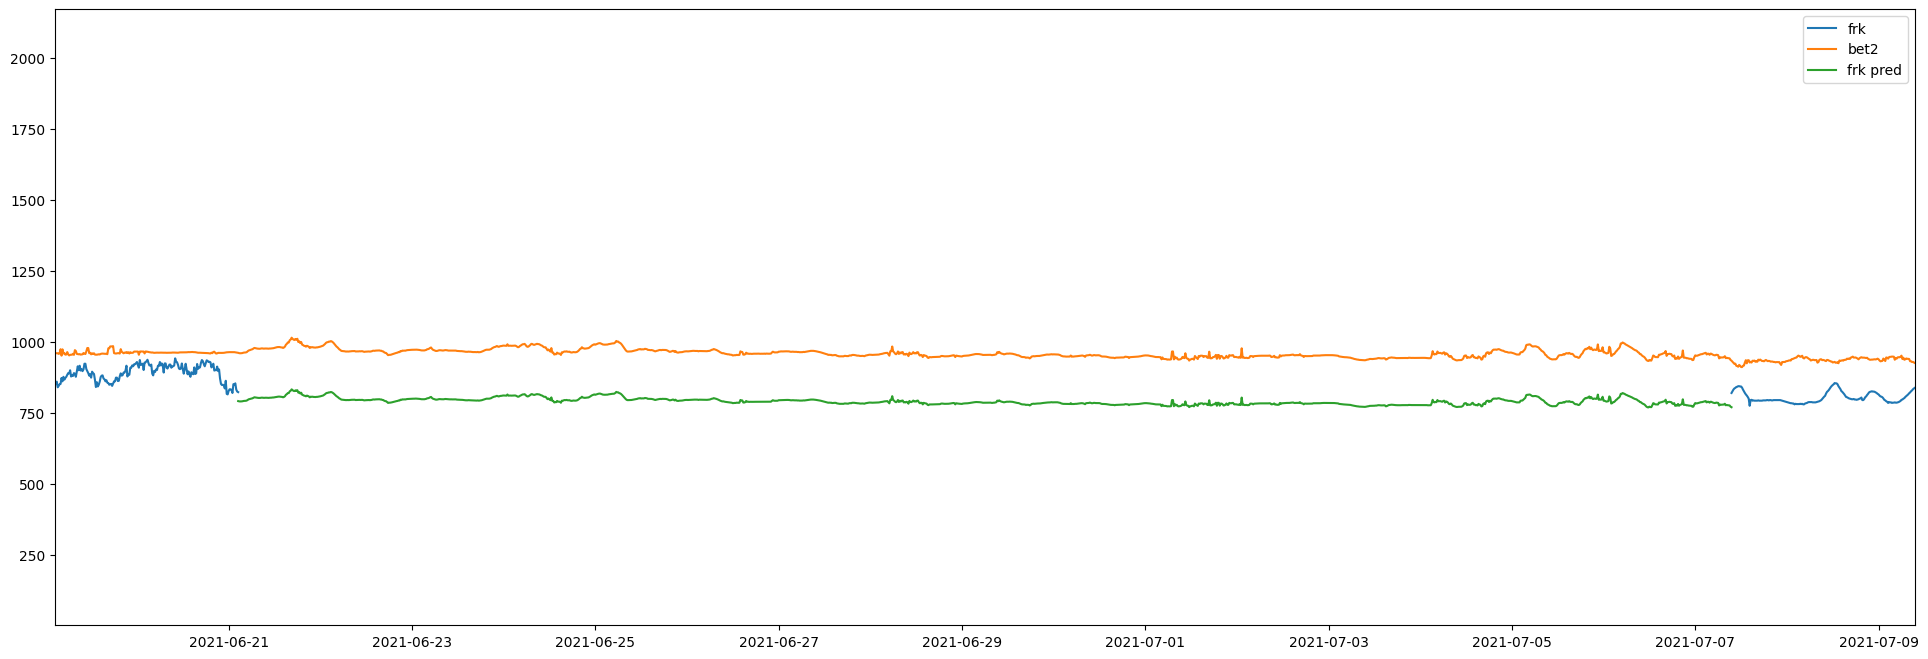

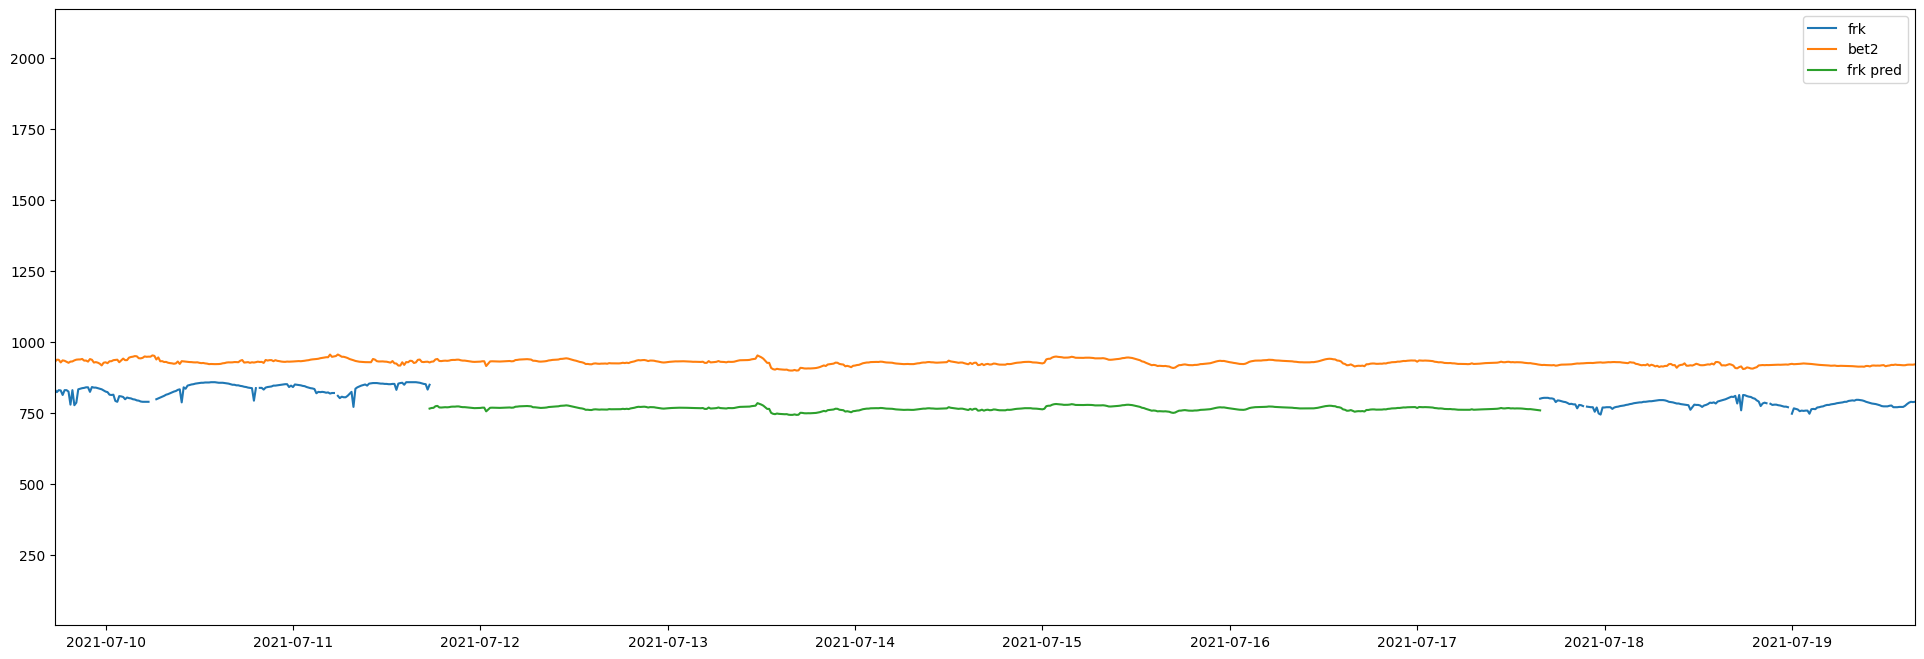

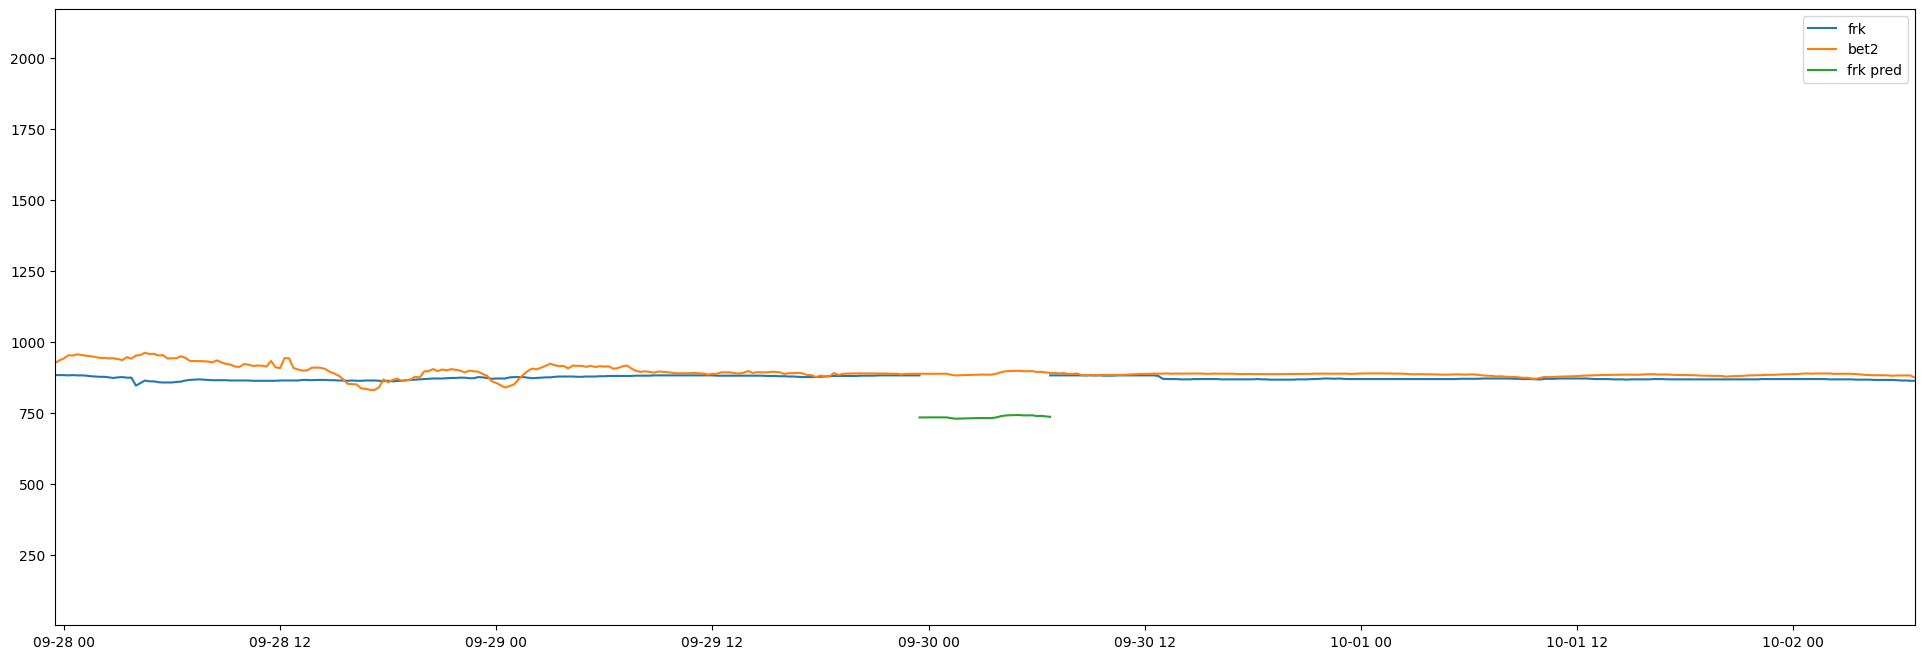

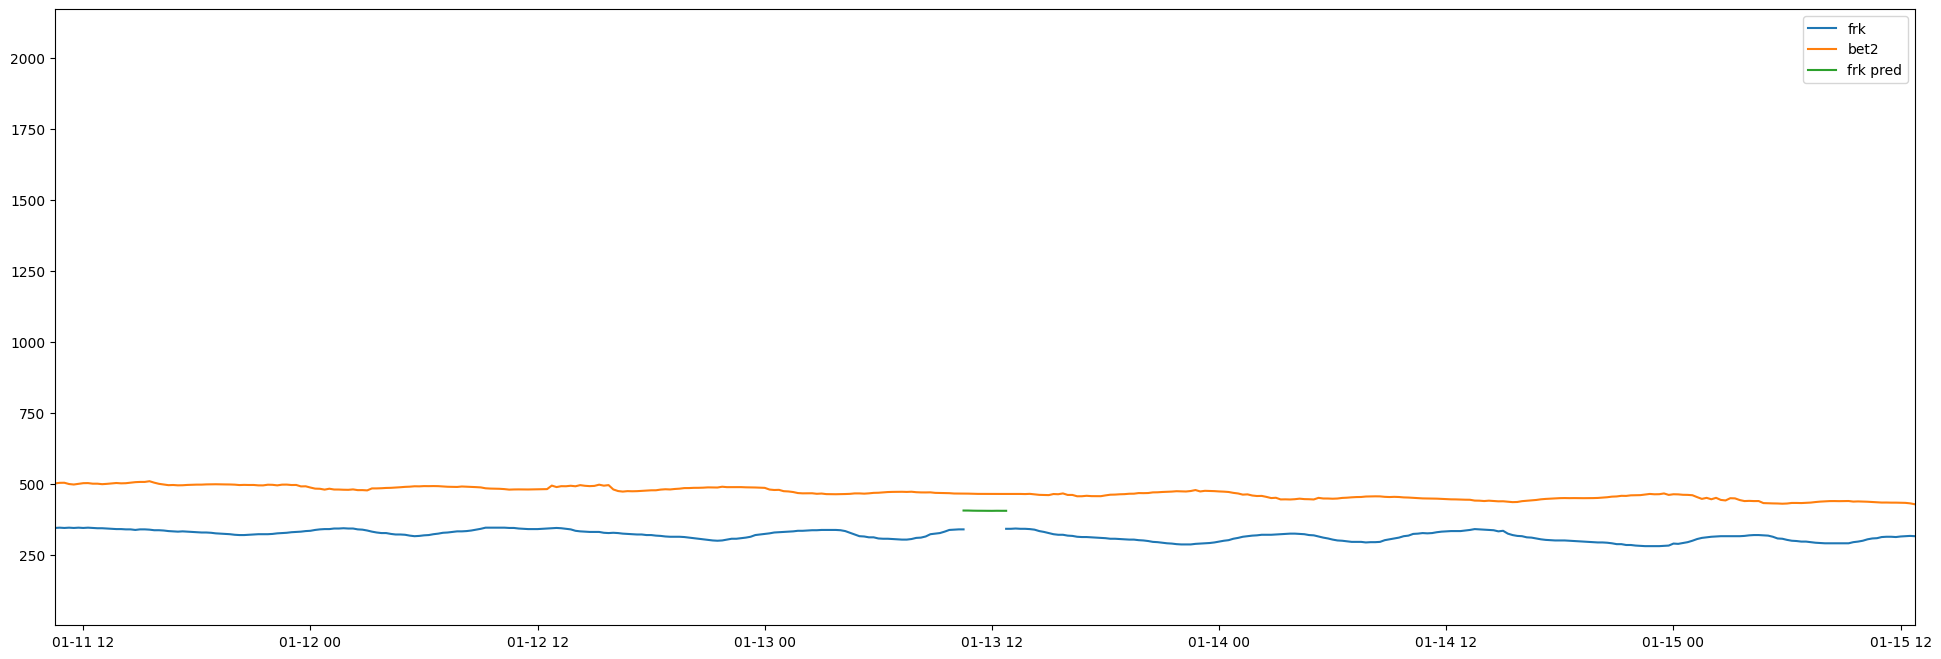

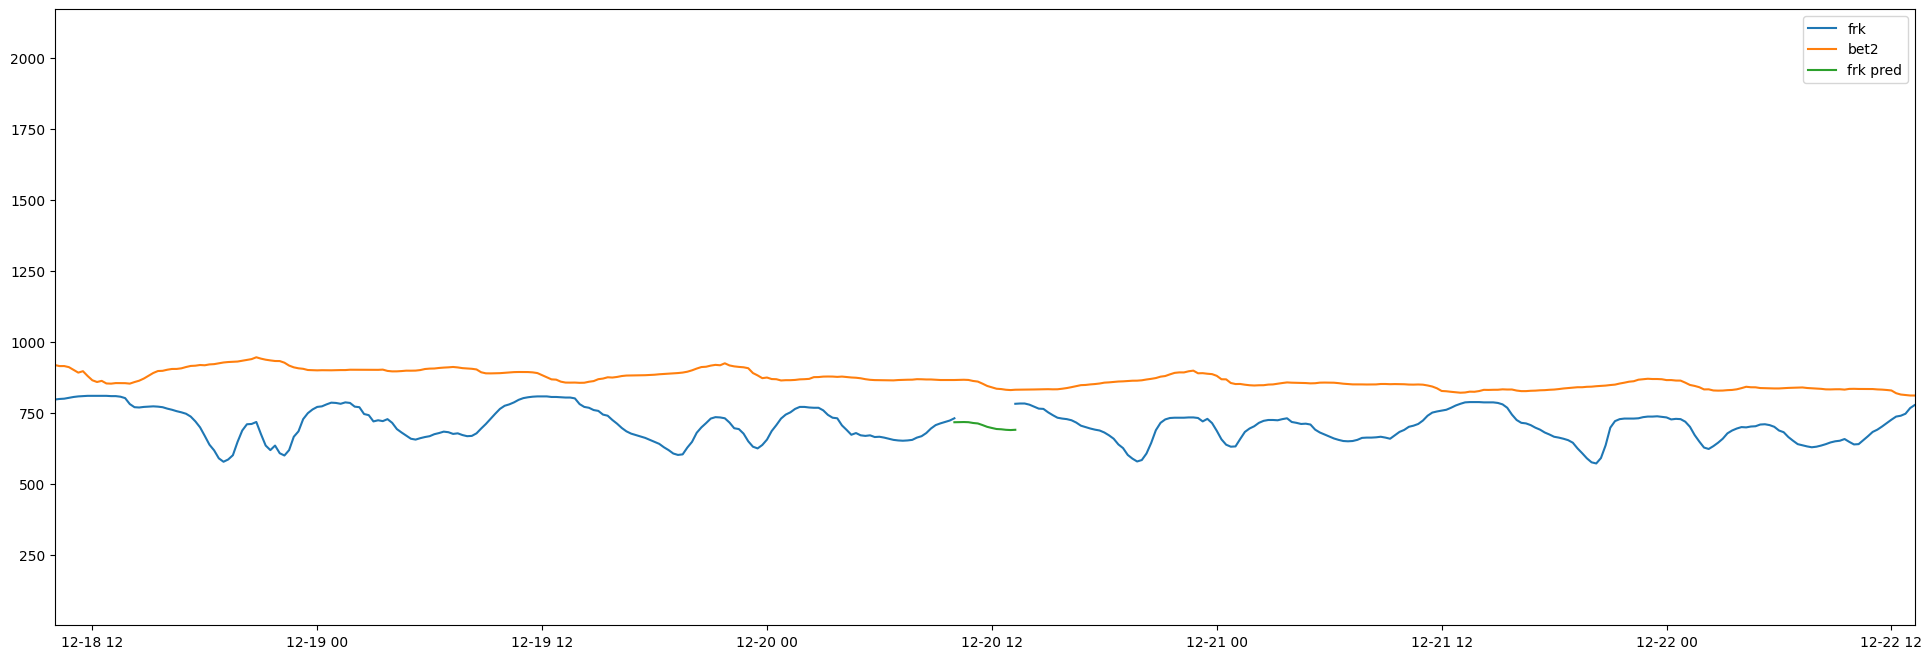

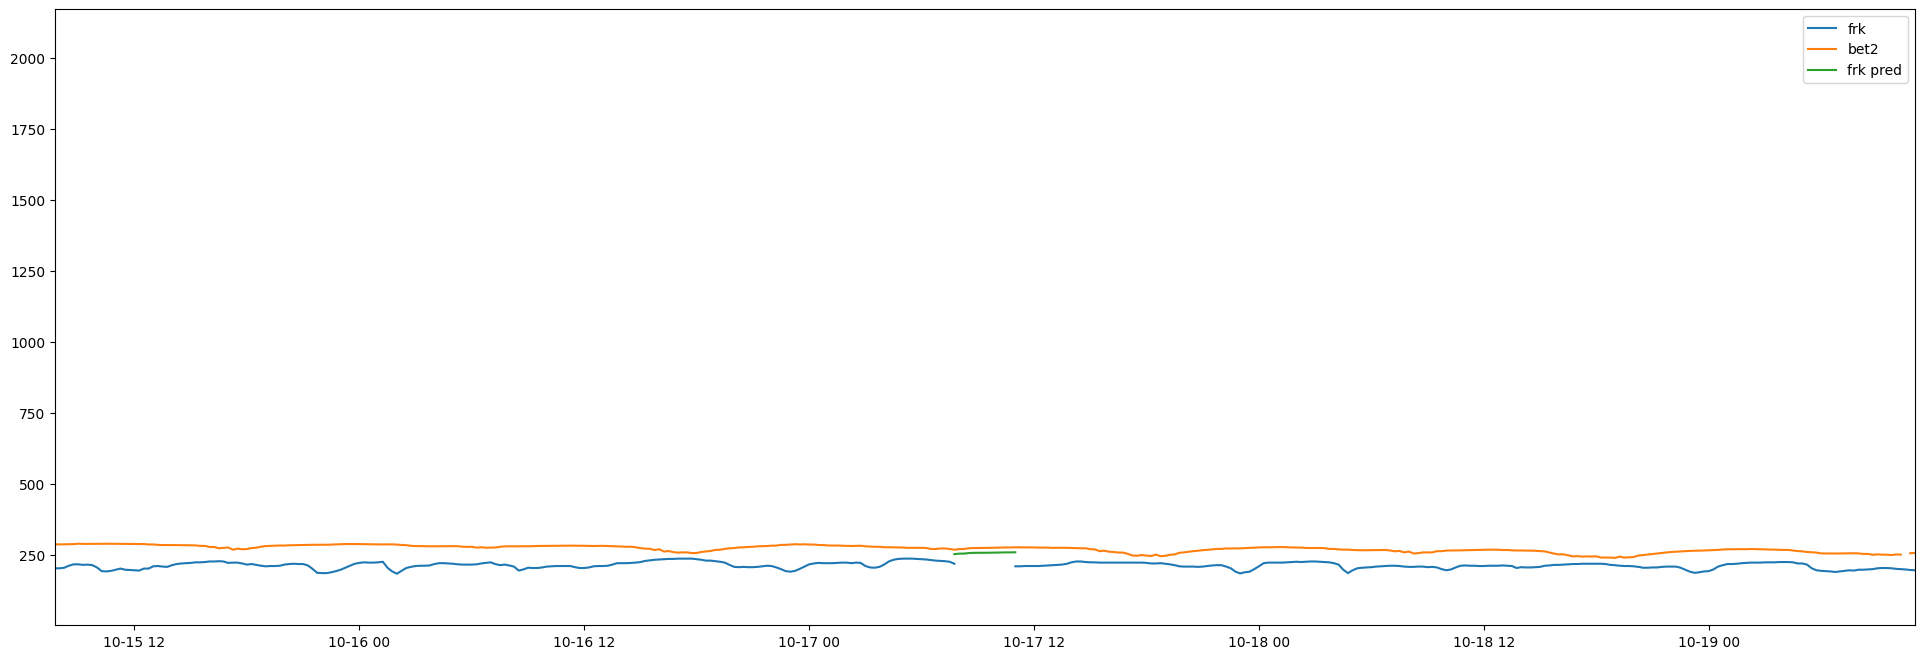

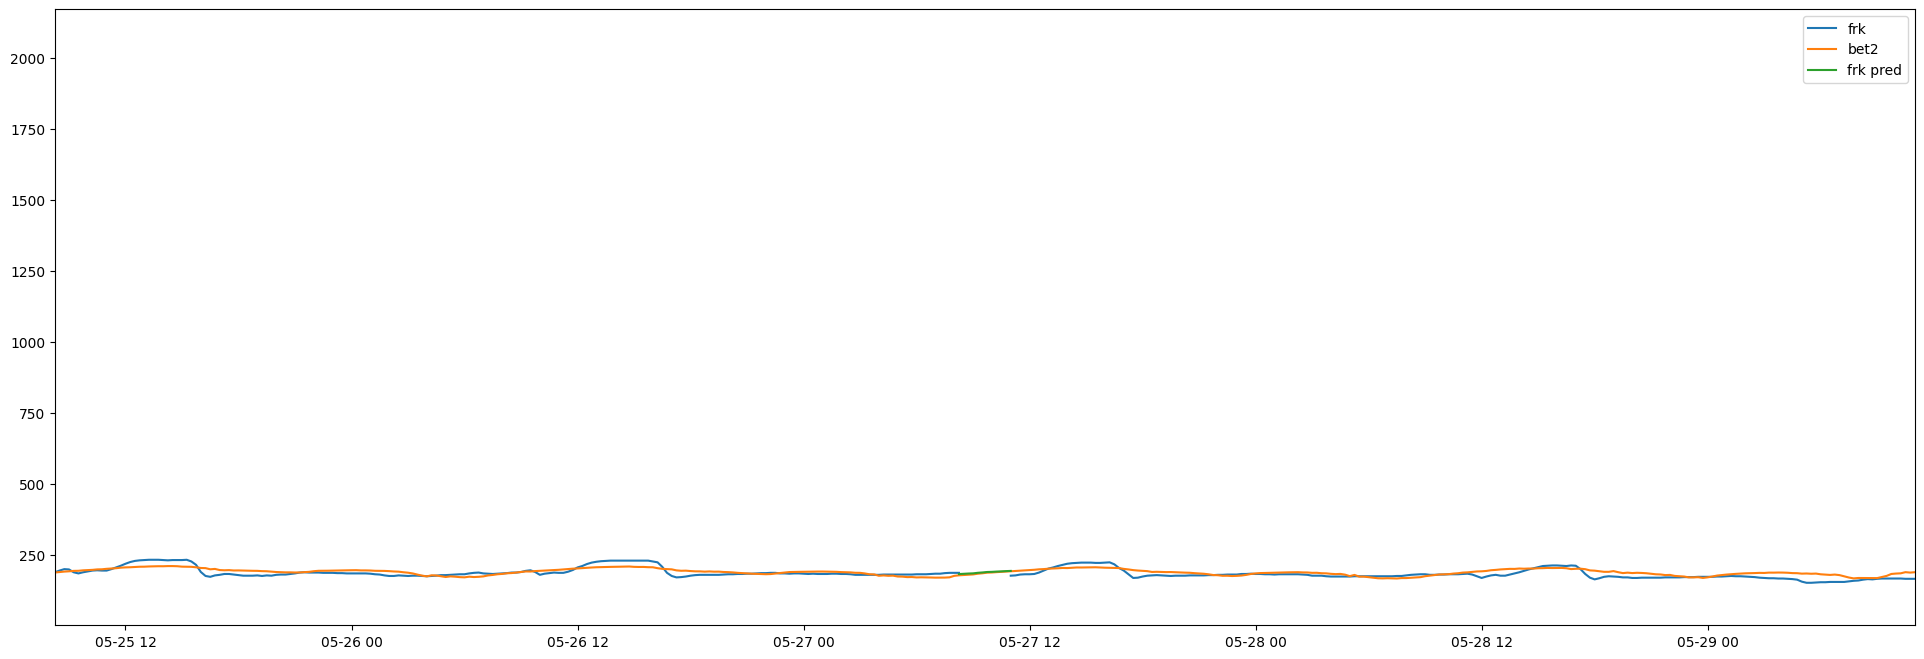

In [28]:
for g in frk_out:
    start=pd.to_datetime(g[0])-pd.Timedelta('15min')
    end=pd.to_datetime(g[1])+pd.Timedelta('15min')
    frk_gap=bet2_dms.loc[start:end]
    frk_pred=reg.predict(frk_gap.values.reshape(-1, 1))
    #dates2fill=pd.date_range(start,end,freq='15min')
    
    fig, ax = plt.subplots(figsize=(24,8))
    ax.plot(frk_dms, label='frk')
    ax.plot(bet2_dms, label ='bet2')
    ax.plot(bet2_dms.loc[start:end].index,frk_pred,label='frk pred')
    ax.set_xlim(start-pd.Timedelta('48h'),end+pd.Timedelta('48h'))
    #ax.set_ylim(500,1100)
    plt.legend()

In [29]:
# gap filling is not ideal, but relatively small portion of data and going to tidally filter

In [30]:
# #what about another gap?
# #try predicting what would go in the gaps
# #first gap in hol2: 2013-10-14 23:30:00', '2013-10-17 12:30:00'
# #'2018-10-25 18:45:00', '2018-10-29 11:45:00'
# hllgap=hll_dms.loc[pd.to_datetime('2018-10-25 18:45:00'):pd.to_datetime('2018-10-29 11:45:00')]
# hol2_pred=reg.predict(hllgap.values.reshape(-1, 1))
# fig, ax = plt.subplots(figsize=(24,8))
# ax.plot(hol2_dms, label='hol2')
# ax.plot(hll_dms, label ='hll')
# ax.plot(hll_dms.loc[pd.to_datetime('2018-10-25 18:45:00'):pd.to_datetime('2018-10-29 11:45:00')].index,hol2_pred,label='hol2 pred')
# ax.set_xlim(datetime(2018,10,25),datetime(2018,10,30))
# ax.set_ylim(500,1000)
# plt.legend()

In [31]:
# np.sum(np.isnan(hol2_dms.loc[pd.to_datetime('2018-10-25 18:45:00'):pd.to_datetime('2018-10-29 11:45:00')]['Salinity[mS/cm]'].values))

NameError: name 'hol2_dms' is not defined

# try gapfilling the larger hol2 gaps with hll

In [32]:
gapmin=pd.Timedelta('122min')
frk_lg_gaps=find_gaps(frk_sm_filled,gapmin)
frk_lg_gaps

/global/home/users/jennaisrael/.conda/envs/schimpy/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/global/home/users/jennaisrael/.conda/envs/schimpy/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


[('2021-06-21 02:45:00', '2021-07-07 09:15:00'),
 ('2021-07-11 17:45:00', '2021-07-17 15:30:00'),
 ('2021-09-29 23:45:00', '2021-09-30 06:30:00'),
 ('2022-01-13 10:45:00', '2022-01-13 12:30:00'),
 ('2022-12-20 10:15:00', '2022-12-20 13:00:00'),
 ('2023-10-17 08:00:00', '2023-10-17 10:45:00'),
 ('2024-05-27 08:30:00', '2024-05-27 10:45:00')]

In [35]:
frk_filled=frk_sm_filled.copy()
for g in frk_lg_gaps:
# test=('2015-07-12 07:00:00', '2015-07-12 08:30:00')
# g=test
# flag=0
# if g==test:
    #fixed the function
    start=pd.to_datetime(g[0])#+pd.Timedelta('15min')
    end=pd.to_datetime(g[1])#-pd.Timedelta('15min')
    if start == end:
        dates2fill=start
        num2fill=1
    else:
        flag=1
        dates2fill=pd.date_range(start,end,freq='15min')
        num2fill=len(dates2fill)
    #make sure they are all nans
    if np.sum(np.isnan(frk_filled.loc[dates2fill]['Salinity[microS/cm]']))==num2fill:
        print('gap is all nans')
        bet2gap=bet2_sm_filled.loc[dates2fill]
        frk_pred=reg.predict(bet2gap.values.reshape(-1, 1)) # needs to be 2d array
        frk_filled['Salinity[microS/cm]'].loc[dates2fill]=frk_pred.reshape(-1) #needs to be a 1D array
        if np.sum(np.isnan(frk_filled.loc[dates2fill]['Salinity[microS/cm]']))== 0:
            print('gap has been filled!')
    else:
        print('Not all nans! Check ' + g[0] +' to '+g[1])   

gap is all nans
gap has been filled!
gap is all nans
gap has been filled!
gap is all nans
gap has been filled!
gap is all nans
gap has been filled!
gap is all nans
gap has been filled!
gap is all nans
gap has been filled!
gap is all nans
gap has been filled!


In [36]:
gapmin=pd.Timedelta('16min')
frk_gapsleft=find_gaps(frk_filled,gapmin)
frk_gapsleft

[]

<AxesSubplot:xlabel='datetime'>

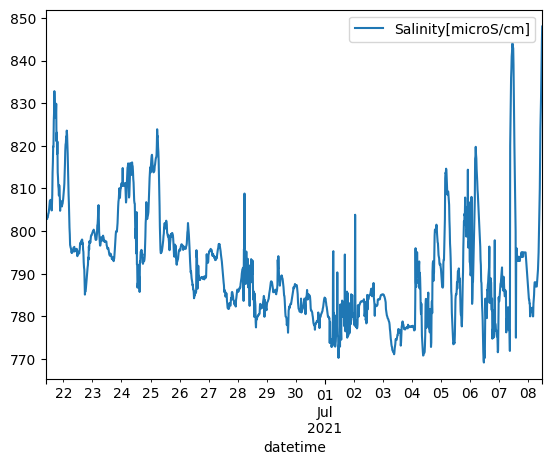

In [38]:
frk_filled.loc[pd.to_datetime('2021-06-21 09:45:00'):pd.to_datetime('2021-07-08 12:00:00')].plot()

In [39]:
frk_filled.loc[pd.to_datetime('2021-06-21 09:45:00'):pd.to_datetime('2021-07-08 12:00:00')]

,Salinity[microS/cm]
datetime,
2021-06-21 09:45:00,803.373242
2021-06-21 10:00:00,803.217779
2021-06-21 10:15:00,803.062316
2021-06-21 10:30:00,802.829123
2021-06-21 10:45:00,803.295510
...,...
2021-07-08 11:00:00,831.000000
2021-07-08 11:15:00,836.000000
2021-07-08 11:30:00,841.000000


In [40]:
frk_filled.first_valid_index()

Timestamp('2015-07-01 00:00:00', freq='15T')

In [41]:
print(len(frk_filled.dropna()))
print(len(frk_filled))

352009
352009


In [43]:
#write to a csv
frk_filled.to_csv('/global/scratch/users/jennaisrael/time_varying_data/dmsdatastore/salinity/frk_gapfilled_2026_01_26.csv')


In [33]:
#load the jersey point data, use the sjj signal to gap fill the jer and bdl for the remaining gaps
dtformat = '%Y-%m-%dT%H:%M:%S'
jer_dms=pd.read_csv("/global/scratch/users/jennaisrael/climate_data_processing/identify_stp/dms_data_jer.csv")
jer_dms=jer_dms.rename(columns={"screened/jer//usbr/JER/ec/microS/cm": "Salinity[mS/cm]"})
jer_dms['datetime']=pd.to_datetime(jer_dms['datetime'],format=dtformat)
jer_dms.set_index("datetime",inplace=True)

#SJJ didn't go online until end of 2009
sjj_dms=pd.read_csv("/global/scratch/users/jennaisrael/climate_data_processing/identify_stp/dms_data_sjj.csv")
sjj_dms=sjj_dms.rename(columns={"screened/sjj//usgs/11337190/ec/microS/cm": "Salinity[mS/cm]"})
sjj_dms['datetime']=pd.to_datetime(sjj_dms['datetime'],format=dtformat)
sjj_dms.set_index("datetime",inplace=True)

blp_dms=pd.read_csv("/global/scratch/users/jennaisrael/time_varying_data/dmsdatastore/salinity/dms_data_blp.csv")
blp_dms=blp_dms.rename(columns={"screened/blp//dwr_ncro/B95029/ec/microS/cm": "Salinity[mS/cm]"})
blp_dms['datetime']=pd.to_datetime(blp_dms['datetime'],format=dtformat)
blp_dms.set_index("datetime",inplace=True)

#gapfill
jp=jer_dms.fillna(sjj_dms)
jp=jp.asfreq('15min')
#jp_filt=filter_timeseries(jp)

In [34]:
#what are the gaps in the partially filled jp?
gapmin=pd.Timedelta('16min')
jp_out=find_gaps(jp,gapmin)
jp_out

/global/home/users/jennaisrael/.conda/envs/schimpy/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/global/home/users/jennaisrael/.conda/envs/schimpy/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


[('2009-08-31 10:30:00', '2009-08-31 10:45:00'),
 ('2009-10-12 09:30:00', '2009-10-12 10:00:00'),
 ('2009-11-01 00:00:00', '2009-11-01 00:45:00'),
 ('2009-11-05 10:00:00', '2009-11-05 10:30:00'),
 ('2009-11-24 10:15:00', '2009-11-24 10:30:00'),
 ('2013-10-21 14:45:00', '2013-10-21 14:45:00'),
 ('2017-07-05 14:30:00', '2017-07-05 15:15:00'),
 ('2017-07-06 12:30:00', '2017-07-06 13:15:00'),
 ('2017-07-07 08:30:00', '2017-07-07 09:15:00'),
 ('2018-07-05 21:00:00', '2018-07-05 21:00:00'),
 ('2019-09-19 03:15:00', '2019-09-19 03:15:00'),
 ('2019-09-19 21:30:00', '2019-09-19 21:30:00'),
 ('2023-05-05 12:30:00', '2023-05-05 13:15:00'),
 ('2023-07-25 10:15:00', '2023-07-25 10:15:00'),
 ('2024-01-30 11:45:00', '2024-01-30 11:45:00'),
 ('2024-01-30 18:00:00', '2024-01-30 18:00:00'),
 ('2025-02-19 12:15:00', '2025-02-19 12:15:00'),
 ('2025-03-09 01:30:00', '2025-03-09 01:45:00'),
 ('2025-03-23 07:00:00', '2025-03-23 07:00:00'),
 ('2025-03-23 10:45:00', '2025-03-23 11:30:00'),
 ('2025-03-23 20:00:

In [35]:
#gaps longer than 2 hrs?
gapmin=pd.Timedelta('16min')
gapmax=pd.Timedelta('121min')
jp_smallgaps=find_gaps(jp,gapmin,gapmax)
jp_smallgaps

/global/home/users/jennaisrael/.conda/envs/schimpy/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/global/home/users/jennaisrael/.conda/envs/schimpy/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


[('2009-08-31 10:30:00', '2009-08-31 10:45:00'),
 ('2009-10-12 09:30:00', '2009-10-12 10:00:00'),
 ('2009-11-01 00:00:00', '2009-11-01 00:45:00'),
 ('2009-11-05 10:00:00', '2009-11-05 10:30:00'),
 ('2009-11-24 10:15:00', '2009-11-24 10:30:00'),
 ('2013-10-21 14:45:00', '2013-10-21 14:45:00'),
 ('2017-07-05 14:30:00', '2017-07-05 15:15:00'),
 ('2017-07-06 12:30:00', '2017-07-06 13:15:00'),
 ('2017-07-07 08:30:00', '2017-07-07 09:15:00'),
 ('2018-07-05 21:00:00', '2018-07-05 21:00:00'),
 ('2019-09-19 03:15:00', '2019-09-19 03:15:00'),
 ('2019-09-19 21:30:00', '2019-09-19 21:30:00'),
 ('2023-05-05 12:30:00', '2023-05-05 13:15:00'),
 ('2023-07-25 10:15:00', '2023-07-25 10:15:00'),
 ('2024-01-30 11:45:00', '2024-01-30 11:45:00'),
 ('2024-01-30 18:00:00', '2024-01-30 18:00:00'),
 ('2025-02-19 12:15:00', '2025-02-19 12:15:00'),
 ('2025-03-09 01:30:00', '2025-03-09 01:45:00'),
 ('2025-03-23 07:00:00', '2025-03-23 07:00:00'),
 ('2025-03-23 10:45:00', '2025-03-23 11:30:00'),
 ('2025-03-23 23:00:

In [36]:
#iterate through the gaps
jp_sm_filled=jp.copy()
for g in jp_smallgaps:
    #to linearly interpolate we need the values on the other side
    start=pd.to_datetime(g[0])-pd.Timedelta('15min')
    end=pd.to_datetime(g[1])+pd.Timedelta('15min')
    dates2fill=pd.date_range(start,end,freq='15min')
    num2fill=len(dates2fill)
    # if start == end:
    #     dates2fill=start
    #     num2fill=1
    # else:
    #     flag=1
    #     dates2fill=pd.date_range(start,end,freq='15min')
    #     num2fill=len(dates2fill)
    #make sure they are all nans
    if np.sum(np.isnan(jp_sm_filled.loc[dates2fill]['Salinity[mS/cm]']))==num2fill-2:
        print('gap is all nans')
        jp_sm_filled['Salinity[mS/cm]'].loc[dates2fill]= jp['Salinity[mS/cm]'].loc[dates2fill].interpolate() #needs to be a 1D array #needs to be a 1D array
        if np.sum(np.isnan(jp_sm_filled.loc[dates2fill]['Salinity[mS/cm]']))== 0:
            print('gap has been filled!')
    else:
        print('Not all nans! Check ' + g[0] +' to '+g[1])   

gap is all nans
gap has been filled!
gap is all nans
gap has been filled!
gap is all nans
gap has been filled!
gap is all nans
gap has been filled!
gap is all nans
gap has been filled!
gap is all nans
gap has been filled!
gap is all nans
gap has been filled!
gap is all nans
gap has been filled!
gap is all nans
gap has been filled!
gap is all nans
gap has been filled!
gap is all nans
gap has been filled!
gap is all nans
gap has been filled!
gap is all nans
gap has been filled!
gap is all nans
gap has been filled!
gap is all nans
gap has been filled!
gap is all nans
gap has been filled!
gap is all nans
gap has been filled!
gap is all nans
gap has been filled!
gap is all nans
gap has been filled!
gap is all nans
gap has been filled!
gap is all nans
gap has been filled!
gap is all nans
gap has been filled!
gap is all nans
gap has been filled!
gap is all nans
gap has been filled!
gap is all nans
gap has been filled!
gap is all nans
gap has been filled!
gap is all nans
gap has been filled!
g

In [37]:
gapmin=pd.Timedelta('16min')
gapmax=pd.Timedelta('121min')
find_gaps(jp_sm_filled,gapmin,gapmax)

/global/home/users/jennaisrael/.conda/envs/schimpy/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/global/home/users/jennaisrael/.conda/envs/schimpy/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


[]

In [38]:
#put the two signals in one dataframe and drop rows where either has a nan
jcomb=pd.concat([jp.rename(columns={"Salinity[mS/cm]":"jp"}),blp_dms.rename(columns={"Salinity[mS/cm]":"blp"})],axis=1).dropna()
jcomb

,jp,blp
datetime,,
2010-02-03 11:00:00,310.0,351.0
2010-02-03 11:15:00,305.0,342.0
2010-02-03 11:30:00,301.0,337.0
2010-02-03 11:45:00,299.0,333.0
2010-02-03 12:00:00,298.0,329.0
...,...,...
2024-03-20 22:00:00,194.0,188.0
2024-03-20 22:15:00,190.0,216.0
2024-03-20 22:30:00,191.0,230.0


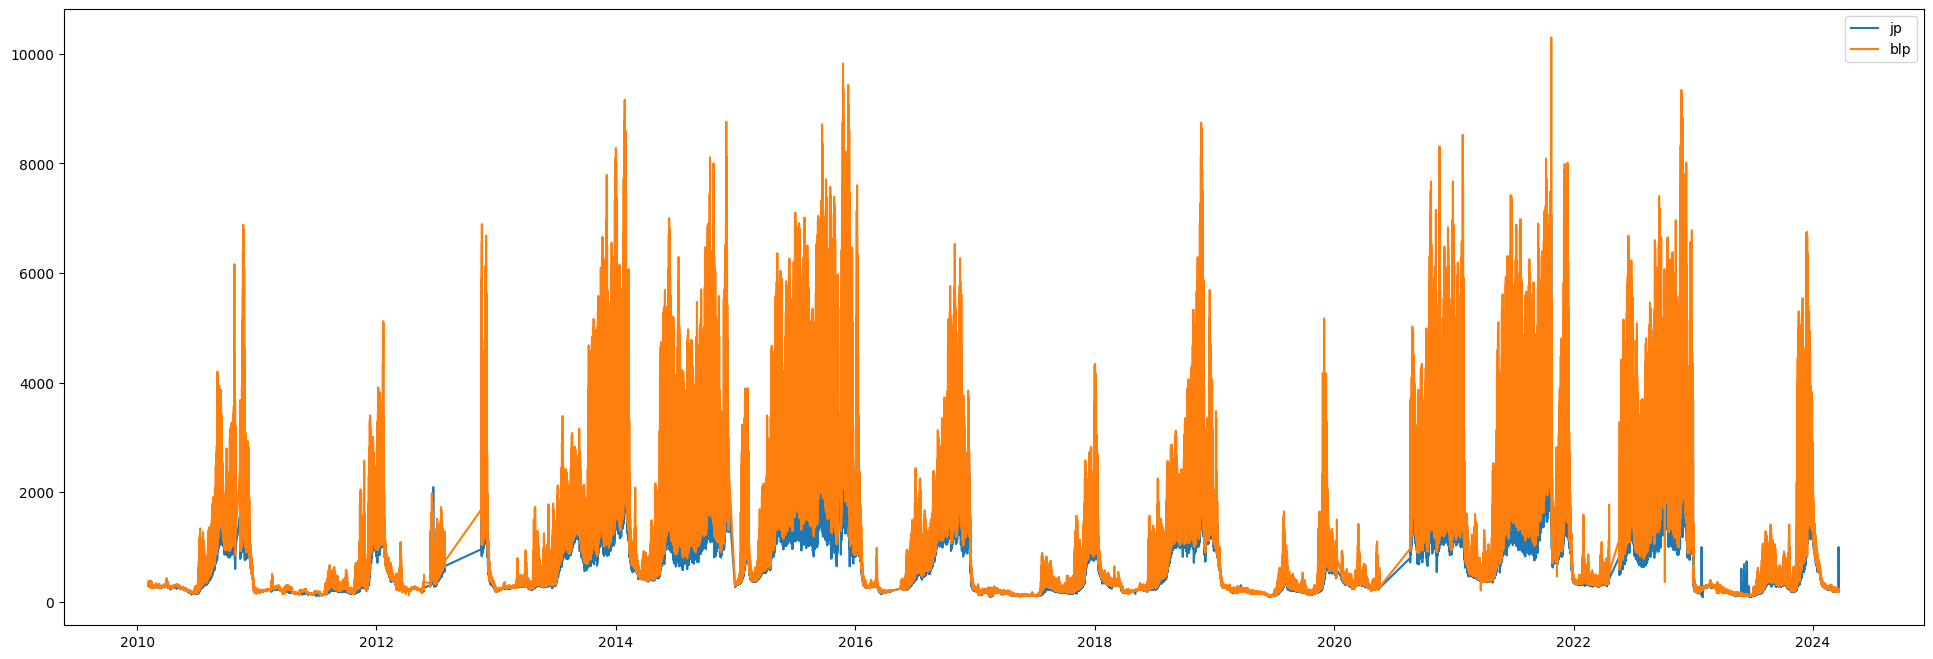

In [39]:
fig, ax = plt.subplots(figsize=(24,8))
ax.plot(jcomb.jp, label='jp')
ax.plot(jcomb.blp, label ='blp')
plt.legend()

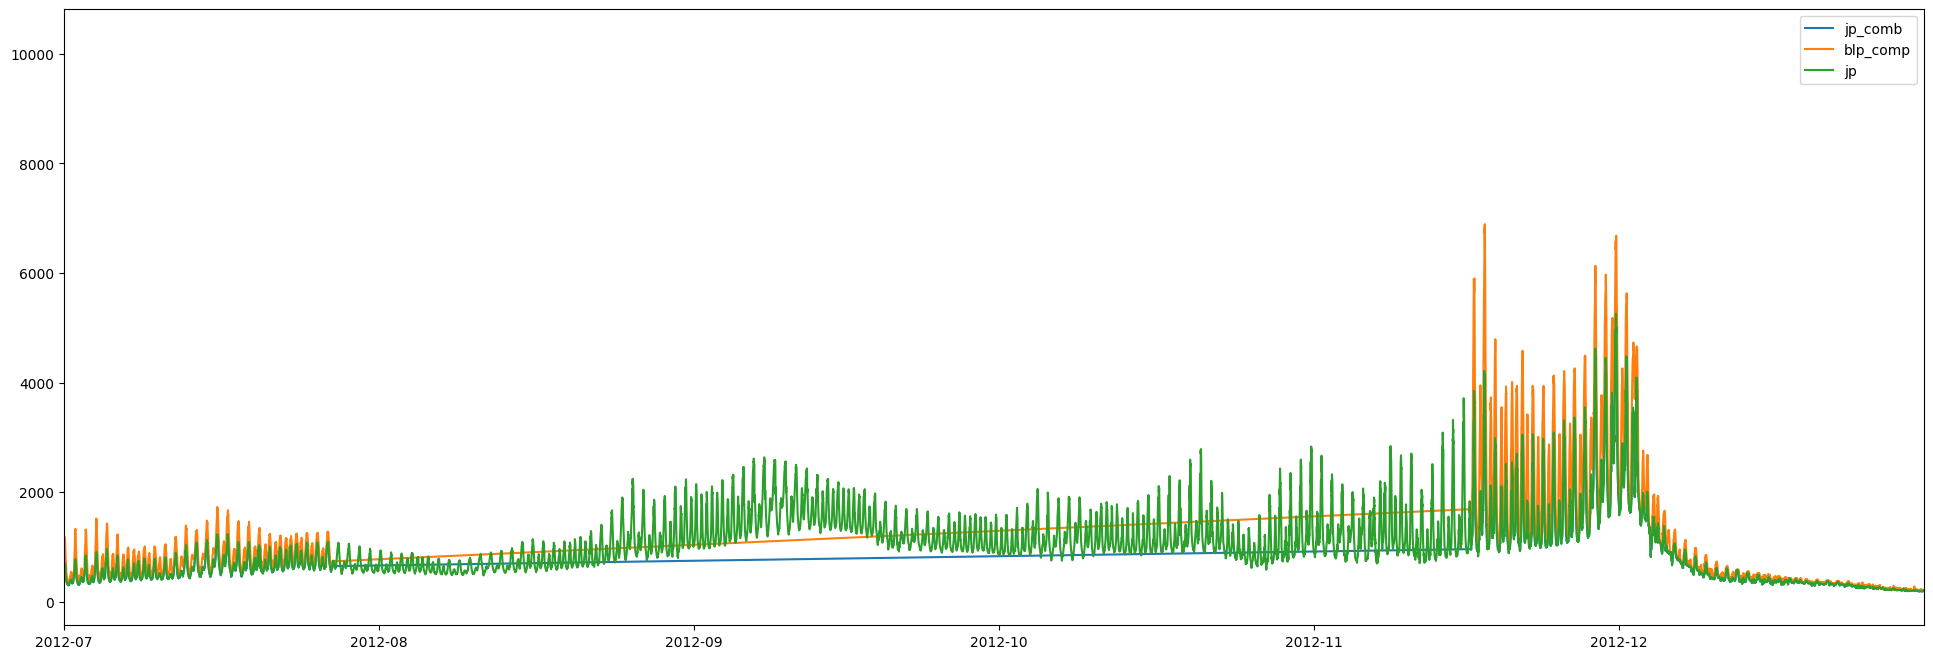

In [40]:
fig, ax = plt.subplots(figsize=(24,8))
ax.plot(jcomb.jp, label='jp_comb')
ax.plot(jcomb.blp, label ='blp_comp')
ax.plot(jp, label='jp')
ax.set_xlim(pd.to_datetime('2012-07-01'),pd.to_datetime('2012-12-31'))
plt.legend()

In [41]:
Xjp= jcomb.blp.values.reshape(-1, 1)
yjp= jcomb.jp.values.reshape(-1,1)
regjp = LinearRegression().fit(Xjp,yjp)
regjp.score(Xjp, yjp)

0.961213750208633

In [42]:
print(regjp.coef_)
print(regjp.intercept_)

[[0.62889788]]
[99.69057395]


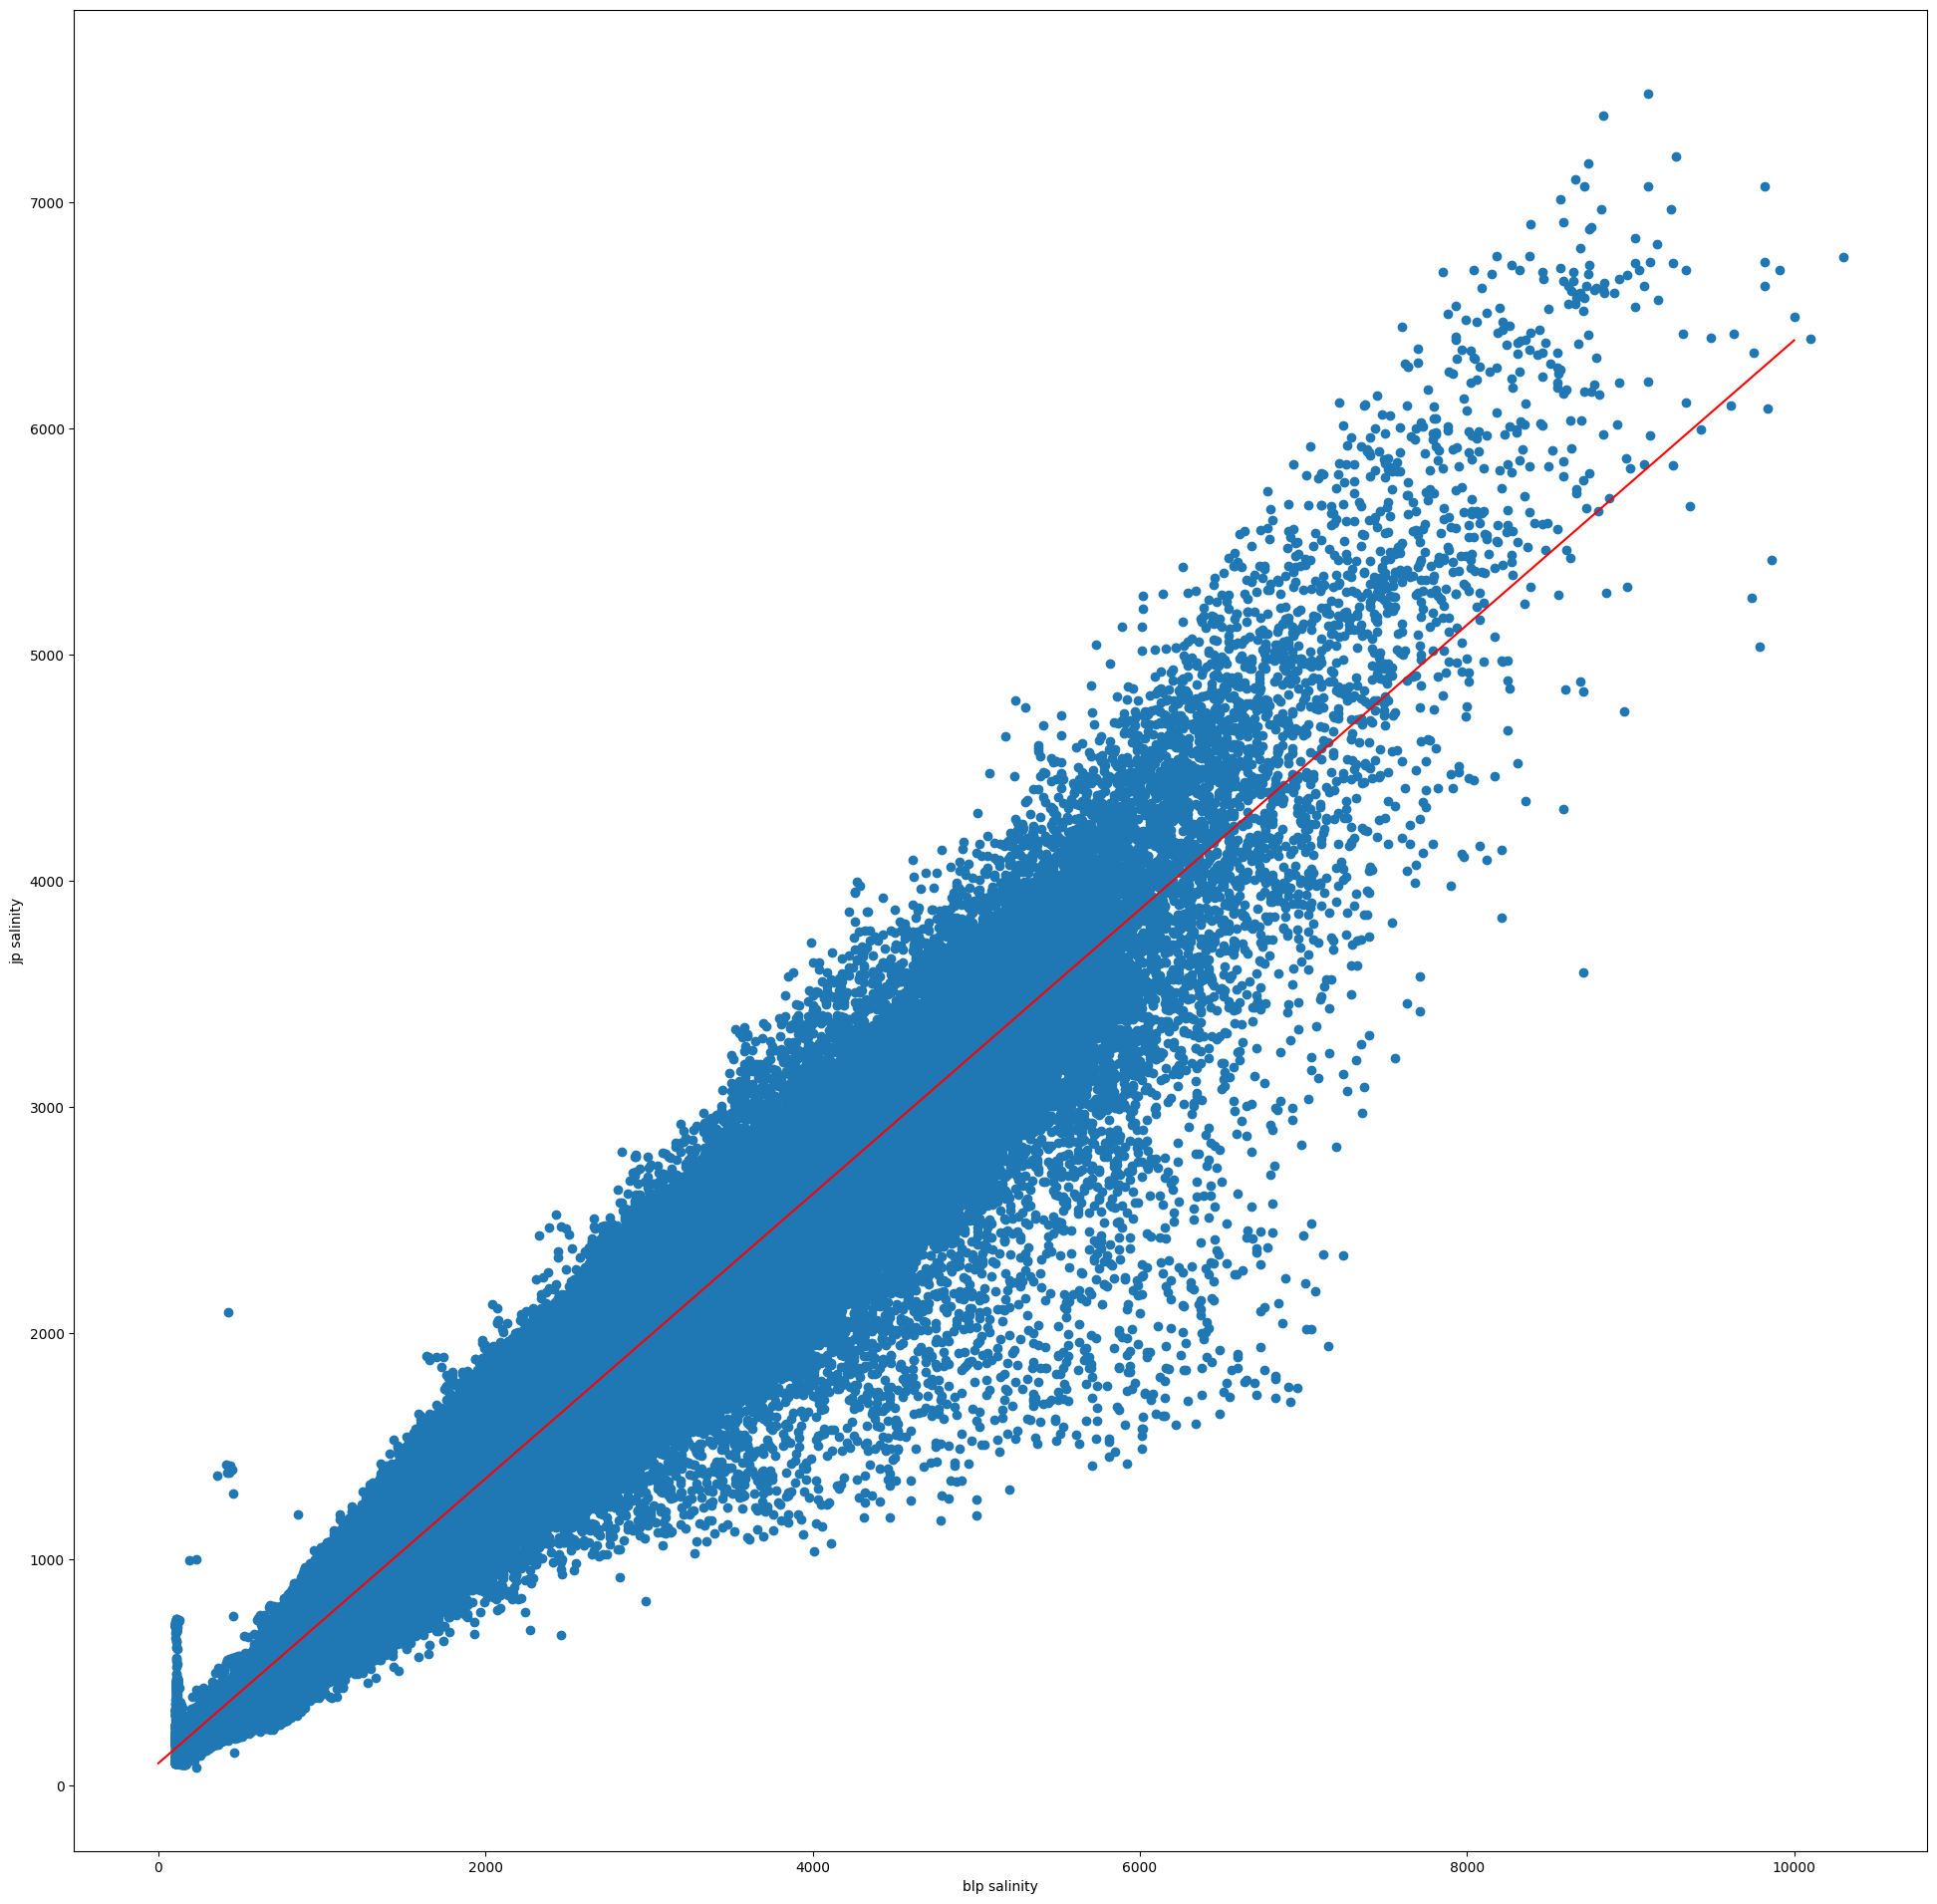

In [43]:
fig, ax = plt.subplots(figsize=(24,24))
ax.scatter(jcomb.blp, jcomb.jp)
linx=np.linspace(0,10000)
liny=regjp.coef_[0]*linx+regjp.intercept_
ax.plot(linx,liny,color='red')
ax.set_ylabel('jp salinity')
ax.set_xlabel('blp salinity')
plt.show()

# try filtering 

In [45]:
frk_filt=filter_timeseries(frk_filled)

(16617.0, 20453.0)

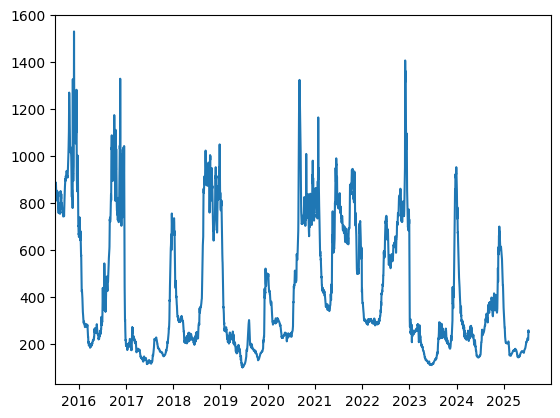

In [46]:
fig, ax =plt.subplots()
ax.plot(frk_filt)
ax.set_xlim(pd.to_datetime('2015-07-01'),pd.to_datetime('2025-12-31'))

In [ ]:
# boxcar filter 

(15522.0, 15705.0)

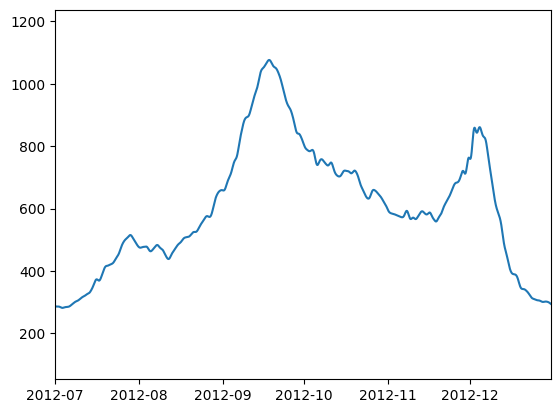

In [38]:
fig, ax =plt.subplots()
ax.plot(hol2_filt)
ax.set_xlim(pd.to_datetime('2012-07-01'),pd.to_datetime('2012-12-31'))

# function troubleshooting

In [ ]:
#this function's output doesn't make much sense to me
# describe_series_gaps(hol2_dms,'hol2',4)

In [5]:
#something is wrong with my function
gapmin=pd.Timedelta('16 min')
sjj_dropna=hol2_dms.dropna()
sjj_dropna['date_col']=np.array([d.to_datetime64() for d in sjj_dropna.index])
#gapmin1=pd.Timedelta('16 min')
mask1=sjj_dropna.date_col.diff().gt(gapmin)
# # get values
starts = sjj_dropna.loc[mask1.shift(-1, fill_value=False), 'date_col'].add(gapmin).astype(str)
stops = sjj_dropna.loc[mask1, 'date_col'].sub(gapmin).astype(str)
# # build output
# out = list(zip(starts, stops))
starts

/global/home/users/jennaisrael/.conda/envs/schimpy/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


datetime
2009-09-21 11:00:00    2009-09-21 11:16:00
2010-01-14 10:45:00    2010-01-14 11:01:00
2010-07-08 11:15:00    2010-07-08 11:31:00
2011-01-10 12:00:00    2011-01-10 12:16:00
2011-02-01 12:00:00    2011-02-01 12:16:00
                              ...         
2025-08-05 09:45:00    2025-08-05 10:01:00
2025-08-06 10:00:00    2025-08-06 10:16:00
2025-08-08 01:45:00    2025-08-08 02:01:00
2025-08-08 10:45:00    2025-08-08 11:01:00
2025-08-08 12:00:00    2025-08-08 12:16:00
Name: date_col, Length: 171, dtype: object

In [6]:
mask1

datetime
2009-09-03 12:00:00    False
2009-09-03 12:15:00    False
2009-09-03 12:30:00    False
2009-09-03 12:45:00    False
2009-09-03 13:00:00    False
                       ...  
2025-09-07 22:00:00    False
2025-09-07 22:15:00    False
2025-09-07 22:30:00    False
2025-09-07 22:45:00    False
2025-09-07 23:00:00    False
Name: date_col, Length: 558677, dtype: bool

In [58]:
gapmin

Timedelta('0 days 00:16:00')

In [7]:
gapmax=pd.Timedelta('121 min')
mask2=sjj_dropna.date_col.diff().lt(gapmax)
mask2

datetime
2009-09-03 12:00:00    False
2009-09-03 12:15:00     True
2009-09-03 12:30:00     True
2009-09-03 12:45:00     True
2009-09-03 13:00:00     True
                       ...  
2025-09-07 22:00:00     True
2025-09-07 22:15:00     True
2025-09-07 22:30:00     True
2025-09-07 22:45:00     True
2025-09-07 23:00:00     True
Name: date_col, Length: 558677, dtype: bool

In [8]:
pd.merge(mask1,mask2)

,date_col
0,False
1,False
2,False
3,False
4,False
...,...
106700462,True
106700463,True
106700464,True
106700465,True


In [ ]:
#the datetime index is different than the calculate "start" and stop", look at the data to identify what the actual gap is 
stops

In [ ]:
hol2_dms.loc[datetime(2010,7,8,10,0,0,0):datetime(2010,7,8,13,0,0,0)].plot()

In [ ]:
hol2_dms.loc[datetime(2010,7,8,10,0,0,0):datetime(2010,7,8,13,0,0,0)]

In [ ]:
teststarts = sjj_dropna.loc[mask1.shift(-1, fill_value=False), 'date_col'].astype(str)[0]
teststops = sjj_dropna.loc[mask1, 'date_col'].astype(str)[0]
print(teststarts)
print(teststops)

In [ ]:
sjj_dropna.date_col.diff().plot()

In [ ]:
sjj_dropna.date_col.diff().max()

In [ ]:
gapmin=pd.Timedelta('16 min')
hol2_out=find_gaps(hol2_dms,gapmin)
hol2_out


In [ ]:
gapmin=pd.Timedelta('31 min')
hol2_out=find_gaps(hol2_dms,gapmin)
hol2_out


In [ ]:
hol2_dms.loc[datetime(2012,7,12):datetime(2012,7,13)].plot()

In [ ]:
# datetime(year, month, day, hour, minute, second, microsecond)
hol2_dms.loc[datetime(2012,7,12,5,0,0,0):datetime(2012,7,12,8,0,0,0)]

In [ ]:
hll_out=find_gaps(hll_dms,gapmin)
hll_out

In [ ]:
pd.read_csv("/global/scratch/users/jennaisrael/time_varying_data/dmsdatastore/salinity/dms_data_hll.csv")